# Analysis of predictions on yellow fever simulated reads

**From local files**

**Plan and Actions**



# 1. Imports and setup environment

In [ ]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [ ]:
# Import all required packages
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from matplotlib.gridspec import GridSpec
from nbdev import show_doc
from pandas import HDFStore
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Any, Generator

# Setup the notebook for development
nb_setup()

from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader, TextFileBaseReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.core import ProjectFileSystem

Set autoreload mode


List all computing devices available on the machine

# 2. Setup paths to files

Key folders and system information

In [ ]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


List of selected reference sequences

In [ ]:
p2list_refseqs = pfs.data/'ncbi/other/yf/YF_2023-accessions-in-ds-and-distance-matrix.csv'
assert p2list_refseqs.exists()

df_refseqs = pd.read_csv(p2list_refseqs, index_col=0)
selected_refseqs = df_refseqs.index.to_list()
display(df_refseqs.head(3))
selected_refseqs[:3]

,refseq_accession,organism
refseqid,,
11089:ncbi:1,AY968064,Angola_1971
11089:ncbi:2,U54798,Ivory_Coast_1982
11089:ncbi:4,AY572535,Gambia_2001


['11089:ncbi:1', '11089:ncbi:2', '11089:ncbi:4']

Distance matrix

In [ ]:
p2distances = pfs.data/'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
p2distances.exists()
distances = pd.read_csv(p2distances, index_col=0)
distances

,YFV_Cameroon_2023,YFV_CAR_2019,U21056_senegal_1927,JX898870_senegal_1996,U23574_Senegal_1965,JX898868_Senegal_1995,JX898873_ArD149214_Senegal_2000,JX898874_ArD149194_Senegal_2000,JX898875_Senegal_2000,JX898876_Senegal_2001,...,MH666058_Brazil_2016,MF370547_Brazil_2017,MK583152_Brazil_SaoPaulo_2017,KY885001_Brazil_2017,MW308134_Brazil_2018,MK760660_Netherlands_2018,MK333805_Brazil_IlhaGrande_2018,MW308135_Brazil_2019,MZ604867_Brazil_2019,MZ712143_Brazil_2021
,,,,,,,,,,,,,,,,,,,,,
YFV_Cameroon_2023,0%,4%,19%,19%,19%,19%,19%,19%,19%,19%,...,19%,18%,19%,19%,19%,19%,19%,19%,19%,19%
YFV_CAR_2019,4%,0%,19%,18%,18%,18%,18%,18%,18%,18%,...,19%,19%,19%,19%,19%,19%,19%,19%,19%,19%
U21056_senegal_1927,19%,19%,0%,4%,4%,4%,5%,5%,5%,4%,...,15%,15%,15%,15%,15%,15%,15%,15%,15%,15%
JX898870_senegal_1996,19%,18%,4%,0%,3%,0%,3%,3%,3%,3%,...,15%,15%,15%,15%,15%,15%,15%,15%,15%,15%
U23574_Senegal_1965,19%,18%,4%,3%,0%,3%,4%,4%,4%,3%,...,15%,15%,15%,15%,15%,15%,15%,15%,15%,15%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK760660_Netherlands_2018,19%,19%,15%,15%,15%,15%,15%,15%,15%,15%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
MK333805_Brazil_IlhaGrande_2018,19%,19%,15%,15%,15%,15%,15%,15%,15%,15%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
MW308135_Brazil_2019,19%,19%,15%,15%,15%,15%,15%,15%,15%,15%,...,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


In [ ]:
p2report_dir = pfs.data/'ncbi/infer_results/yf-ncbi/local-inf'
assert p2report_dir.is_dir()
report_files = sorted([p for p in p2report_dir.glob('*.csv') if not p.stem.endswith('original')])
report_files[:3]

[Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_1.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_10.csv'),
 Path('/home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/local-inf/11089_ncbi_12.csv')]

Load all reports into a dictionary, after adding the accuracy column

In [ ]:
df = None

for p in report_files:
    df_p = pd.read_csv(p)
    df_p['accuracy'] = df_p['lbl_pred'] == df_p['lbl_true']
    df = df_p if df is None else pd.concat([df, df_p])
# 
df.sample(3)

,readid,refseqid,refsource,refseq_strand,taxonomyid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,preds_score,probs_score,accuracy
6179,11089:ncbi:14-10821,11089:ncbi:14,ncbi,+,11089,118,118,1225,1,118,130,4,12,144,0.525888,0.196714,True
6790,11089:ncbi:30-10210,11089:ncbi:30,ncbi,-,11089,118,13,3294,4,20,62,13,136,19,-0.022185,0.021338,False
11942,11089:ncbi:58-4877,11089:ncbi:58,ncbi,-,11089,118,32,3519,6,4,12,32,10,22,-0.000000,0.002041,False


# Analysis

Metrics: in effect, we have a binary classification problem here because all the simread are from yellow fever. This means prediction are either TP or FN. Consequently, accuracy = recall and we cannot evaluate precision.

## Accuracy per reference sequence

In [ ]:
df_refseqs['mean acc'] = df.groupby('refseqid')['accuracy'].mean()
df_refseqs

,refseq_accession,organism,mean acc
refseqid,,,
11089:ncbi:1,AY968064,Angola_1971,0.166765
11089:ncbi:2,U54798,Ivory_Coast_1982,0.876000
11089:ncbi:4,AY572535,Gambia_2001,0.996000
11089:ncbi:6,U21056,Senegal_1927,1.000000
11089:ncbi:7,AY968065,Uganda_1948,0.191176
11089:ncbi:10,GQ379163,Peru_Hsapiens_2007,1.000000
11089:ncbi:12,MF289572,Singapore_2017,1.000000
11089:ncbi:13,KU978764,Sudan_Hsapiens_1941,1.000000
11089:ncbi:14,JX898878,ArD181250_Senegal_2005,0.997647


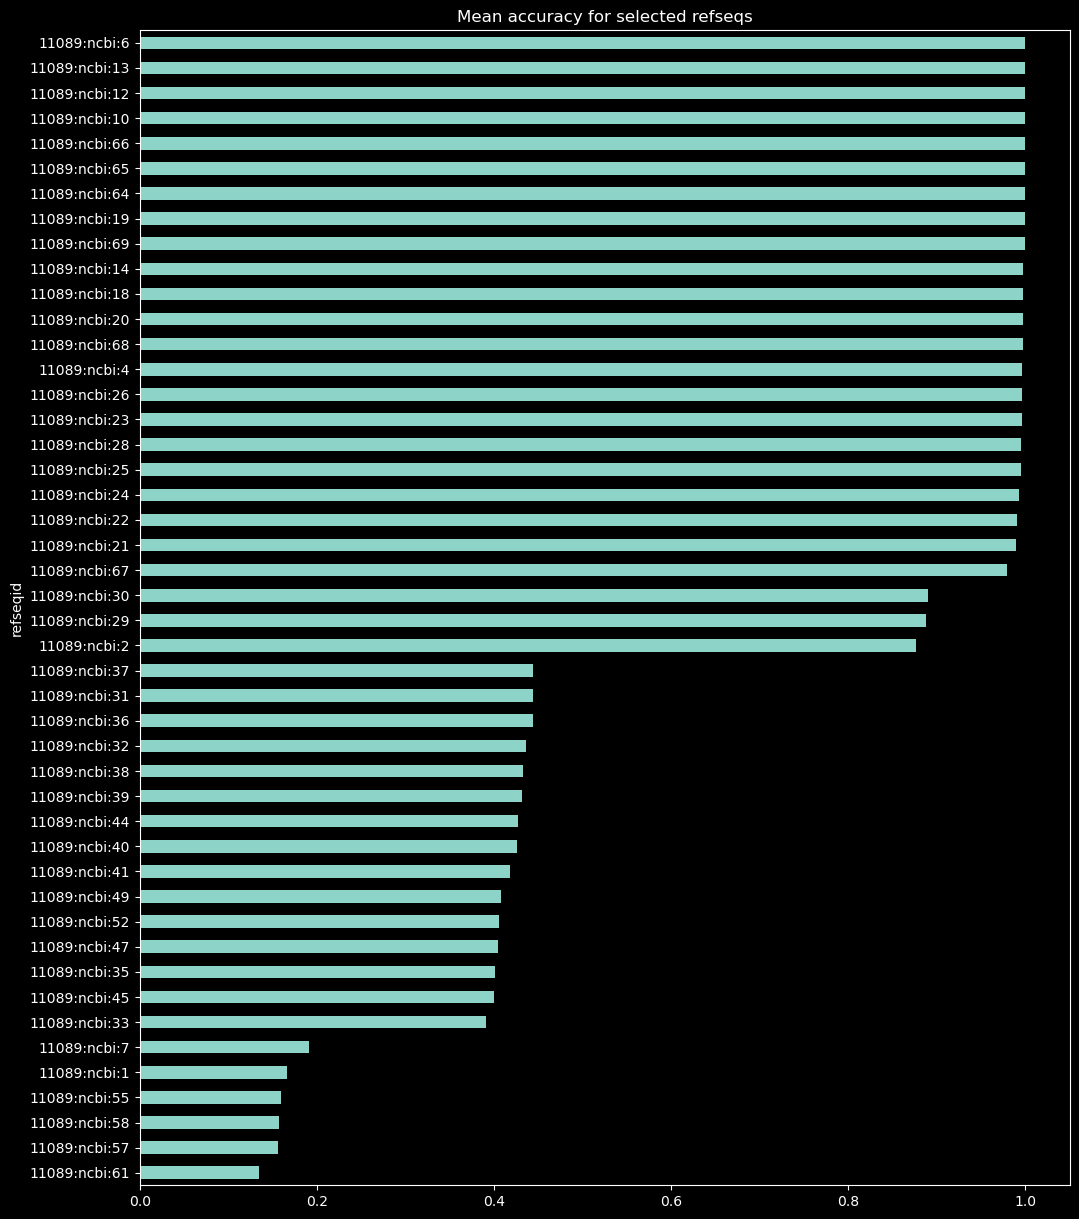

In [ ]:
df_refseqs.sort_values(by='mean acc')['mean acc'].plot(kind='barh', x='mean acc', figsize=(12, 15), title='Mean accuracy for selected refseqs');

Note: all reference sequence have the same lenght, that is 10,237 bp

In [ ]:
refseq_length = 10_237

## Impact of Distance on Accuracy

In [ ]:
p2matrix = pfs.data / 'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
dist_mx = pd.read_csv(p2matrix, index_col=0)
for col in dist_mx.columns:
    dist_mx[col] = dist_mx[col].str.rstrip('%').astype(float)/100
dist_mx

,YFV_Cameroon_2023,YFV_CAR_2019,U21056_senegal_1927,JX898870_senegal_1996,U23574_Senegal_1965,JX898868_Senegal_1995,JX898873_ArD149214_Senegal_2000,JX898874_ArD149194_Senegal_2000,JX898875_Senegal_2000,JX898876_Senegal_2001,...,MH666058_Brazil_2016,MF370547_Brazil_2017,MK583152_Brazil_SaoPaulo_2017,KY885001_Brazil_2017,MW308134_Brazil_2018,MK760660_Netherlands_2018,MK333805_Brazil_IlhaGrande_2018,MW308135_Brazil_2019,MZ604867_Brazil_2019,MZ712143_Brazil_2021
,,,,,,,,,,,,,,,,,,,,,
YFV_Cameroon_2023,0.00,0.04,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,...,0.19,0.18,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
YFV_CAR_2019,0.04,0.00,0.19,0.18,0.18,0.18,0.18,0.18,0.18,0.18,...,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
U21056_senegal_1927,0.19,0.19,0.00,0.04,0.04,0.04,0.05,0.05,0.05,0.04,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
JX898870_senegal_1996,0.19,0.18,0.04,0.00,0.03,0.00,0.03,0.03,0.03,0.03,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
U23574_Senegal_1965,0.19,0.18,0.04,0.03,0.00,0.03,0.04,0.04,0.04,0.03,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK760660_Netherlands_2018,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MK333805_Brazil_IlhaGrande_2018,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MW308135_Brazil_2019,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Map distance matrix index and accession

In [ ]:
distance_accessions = {}
missing=[]
for col in dist_mx.columns:
    regex = re.compile(r'^(?P<accession>\w{1,2}\d*)_(?P<country>.*)_(?P<year>\d\d\d\d)$')
    match = regex.search(col)
    if match: 
        accession = match.group('accession')
        subdict = {
            'accession': accession, 
            'country': match.group('country'), 
            'year': match.group('year'),
            'definition line': col
            } 
        distance_accessions[accession] = subdict
    else:
        missing =+ 1
        print(col, 'could not find the accession')

distance_accessions['U21056']

YFV_Cameroon_2023 could not find the accession
YFV_CAR_2019 could not find the accession
Yellow_fever_YF118_CAR_2018 could not find the accession


{'accession': 'U21056',
 'country': 'senegal',
 'year': '1927',
 'definition line': 'U21056_senegal_1927'}

In [ ]:
for refseqid in df_refseqs.index:
    accession = df_refseqs.loc[refseqid, 'refseq_accession']
    print(f"{accession:10s} {refseqid:15s} {distance_accessions.get(accession, 'not found')['definition line']}")

AY968064   11089:ncbi:1    AY968064_angola_1971
U54798     11089:ncbi:2    U54798_Ivory_Coast_1982
AY572535   11089:ncbi:4    AY572535_Gambia_2001
U21056     11089:ncbi:6    U21056_senegal_1927
AY968065   11089:ncbi:7    AY968065_Uganda_1948
GQ379163   11089:ncbi:10   GQ379163_Peru_2007
MF289572   11089:ncbi:12   MF289572_Singapore_2017
KU978764   11089:ncbi:13   KU978764_Sudan_1941
JX898878   11089:ncbi:14   JX898878_ArD181250_Senegal_2005
JX898877   11089:ncbi:18   JX898877_ArD181464_Senegal_2005
JX898876   11089:ncbi:19   JX898876_Senegal_2001
KU978765   11089:ncbi:20   KU978765_GuineaBissau_1965
JX898870   11089:ncbi:21   JX898870_senegal_1996
JX898868   11089:ncbi:22   JX898868_Senegal_1995
JX898875   11089:ncbi:23   JX898875_Senegal_2000
JX898874   11089:ncbi:24   JX898874_ArD149194_Senegal_2000
JX898873   11089:ncbi:25   JX898873_ArD149214_Senegal_2000
MK292067   11089:ncbi:26   MK292067_Netherlands_2018
MN958078   11089:ncbi:28   MN958078_Nigeria_2018
JX898869   11089:ncbi:29  

In [ ]:
refseqid2index = {refseqid:distance_accessions[accession]['definition line'] for refseqid,accession in zip(df_refseqs.index, df_refseqs.refseq_accession)}
refseqid2index

{'11089:ncbi:1': 'AY968064_angola_1971',
 '11089:ncbi:2': 'U54798_Ivory_Coast_1982',
 '11089:ncbi:4': 'AY572535_Gambia_2001',
 '11089:ncbi:6': 'U21056_senegal_1927',
 '11089:ncbi:7': 'AY968065_Uganda_1948',
 '11089:ncbi:10': 'GQ379163_Peru_2007',
 '11089:ncbi:12': 'MF289572_Singapore_2017',
 '11089:ncbi:13': 'KU978764_Sudan_1941',
 '11089:ncbi:14': 'JX898878_ArD181250_Senegal_2005',
 '11089:ncbi:18': 'JX898877_ArD181464_Senegal_2005',
 '11089:ncbi:19': 'JX898876_Senegal_2001',
 '11089:ncbi:20': 'KU978765_GuineaBissau_1965',
 '11089:ncbi:21': 'JX898870_senegal_1996',
 '11089:ncbi:22': 'JX898868_Senegal_1995',
 '11089:ncbi:23': 'JX898875_Senegal_2000',
 '11089:ncbi:24': 'JX898874_ArD149194_Senegal_2000',
 '11089:ncbi:25': 'JX898873_ArD149214_Senegal_2000',
 '11089:ncbi:26': 'MK292067_Netherlands_2018',
 '11089:ncbi:28': 'MN958078_Nigeria_2018',
 '11089:ncbi:29': 'JX898869_Cote_Ivoire_1973',
 '11089:ncbi:30': 'KU978763_Nigeria_1946',
 '11089:ncbi:31': 'MF004382_Bolivia_1999',
 '11089:ncbi

Create a distance matric including only the selected sequences

In [ ]:
mx = dist_mx.loc[refseqid2index.values(), refseqid2index.values()]
mx

,AY968064_angola_1971,U54798_Ivory_Coast_1982,AY572535_Gambia_2001,U21056_senegal_1927,AY968065_Uganda_1948,GQ379163_Peru_2007,MF289572_Singapore_2017,KU978764_Sudan_1941,JX898878_ArD181250_Senegal_2005,JX898877_ArD181464_Senegal_2005,...,JN620362_Uganda_2010,KU949599_shanghai_2016,MG589641_china_2016,MH633692_China_2016,ON323052_Nigeria_2020,ON323053_Nigeria_2020,ON323054_Nigeria_2020,OM066735_ghana_Damongo_2021,OM066736_ghana_Daboya_2021,OM066737_ghana_Damongo_2021
,,,,,,,,,,,,,,,,,,,,,
AY968064_angola_1971,0.00,0.20,0.18,0.18,0.13,0.19,0.19,0.18,0.18,0.18,...,0.13,0.02,0.02,0.02,0.18,0.19,0.18,0.27,0.26,0.20
U54798_Ivory_Coast_1982,0.20,0.00,0.09,0.10,0.19,0.10,0.11,0.10,0.10,0.10,...,0.19,0.20,0.20,0.20,0.09,0.10,0.10,0.20,0.19,0.13
AY572535_Gambia_2001,0.18,0.09,0.00,0.05,0.18,0.06,0.06,0.05,0.04,0.04,...,0.19,0.18,0.18,0.18,0.04,0.05,0.05,0.14,0.13,0.06
U21056_senegal_1927,0.18,0.10,0.05,0.00,0.18,0.01,0.01,0.00,0.04,0.04,...,0.18,0.18,0.18,0.18,0.02,0.02,0.01,0.15,0.15,0.08
AY968065_Uganda_1948,0.13,0.19,0.18,0.18,0.00,0.19,0.19,0.18,0.18,0.18,...,0.08,0.13,0.13,0.13,0.18,0.19,0.19,0.27,0.26,0.20
GQ379163_Peru_2007,0.19,0.10,0.06,0.01,0.19,0.00,0.01,0.01,0.05,0.05,...,0.19,0.19,0.19,0.19,0.03,0.02,0.02,0.16,0.15,0.08
MF289572_Singapore_2017,0.19,0.11,0.06,0.01,0.19,0.01,0.00,0.01,0.05,0.05,...,0.19,0.19,0.19,0.19,0.03,0.02,0.02,0.16,0.15,0.08
KU978764_Sudan_1941,0.18,0.10,0.05,0.00,0.18,0.01,0.01,0.00,0.04,0.04,...,0.18,0.18,0.18,0.18,0.02,0.01,0.01,0.15,0.15,0.08
JX898878_ArD181250_Senegal_2005,0.18,0.10,0.04,0.04,0.18,0.05,0.05,0.04,0.00,0.00,...,0.18,0.18,0.18,0.18,0.03,0.04,0.04,0.15,0.14,0.07


Select the basis sequence for distance, as one of the sequence with perfect accuraty:

In [ ]:
df_refseqs.loc[df_refseqs['mean acc'] == 1, :]

,refseq_accession,organism,mean acc
refseqid,,,
11089:ncbi:6,U21056,Senegal_1927,1.0
11089:ncbi:10,GQ379163,Peru_Hsapiens_2007,1.0
11089:ncbi:12,MF289572,Singapore_2017,1.0
11089:ncbi:13,KU978764,Sudan_Hsapiens_1941,1.0


Pick `'11089:ncbi:6' U21056	Senegal_1927`, as it the the oldest one with 100% accuracy

In [ ]:
basis_sequence = '11089:ncbi:6'

In [ ]:
distances = mx.loc[refseqid2index[basis_sequence], :]
distances

AY968064_angola_1971                  0.18
U54798_Ivory_Coast_1982               0.10
AY572535_Gambia_2001                  0.05
U21056_senegal_1927                   0.00
AY968065_Uganda_1948                  0.18
GQ379163_Peru_2007                    0.01
MF289572_Singapore_2017               0.01
KU978764_Sudan_1941                   0.00
JX898878_ArD181250_Senegal_2005       0.04
JX898877_ArD181464_Senegal_2005       0.04
JX898876_Senegal_2001                 0.04
KU978765_GuineaBissau_1965            0.04
JX898870_senegal_1996                 0.04
JX898868_Senegal_1995                 0.04
JX898875_Senegal_2000                 0.05
JX898874_ArD149194_Senegal_2000       0.05
JX898873_ArD149214_Senegal_2000       0.05
MK292067_Netherlands_2018             0.05
MN958078_Nigeria_2018                 0.05
JX898869_Cote_Ivoire_1973             0.09
KU978763_Nigeria_1946                 0.09
MF004382_Bolivia_1999                 0.14
JF912181_Brazil_1983                  0.15
JF912179_Br

In [ ]:
ordered_accuracies = df_refseqs.sort_values('mean acc', ascending=False)
ordered_index = ordered_accuracies.index
ordered_distance_index = list(map(refseqid2index.get, ordered_index))
ordered_distances = distances.loc[ordered_distance_index]
ordered_distance_index[:3], ordered_distances[:3]

df_refseqs.loc[ordered_index, 'distance'] = ordered_distances.values
df_refseqs

,refseq_accession,organism,mean acc,distance
refseqid,,,,
11089:ncbi:1,AY968064,Angola_1971,0.166765,0.18
11089:ncbi:2,U54798,Ivory_Coast_1982,0.876000,0.10
11089:ncbi:4,AY572535,Gambia_2001,0.996000,0.05
11089:ncbi:6,U21056,Senegal_1927,1.000000,0.00
11089:ncbi:7,AY968065,Uganda_1948,0.191176,0.18
11089:ncbi:10,GQ379163,Peru_Hsapiens_2007,1.000000,0.01
11089:ncbi:12,MF289572,Singapore_2017,1.000000,0.01
11089:ncbi:13,KU978764,Sudan_Hsapiens_1941,1.000000,0.00
11089:ncbi:14,JX898878,ArD181250_Senegal_2005,0.997647,0.04


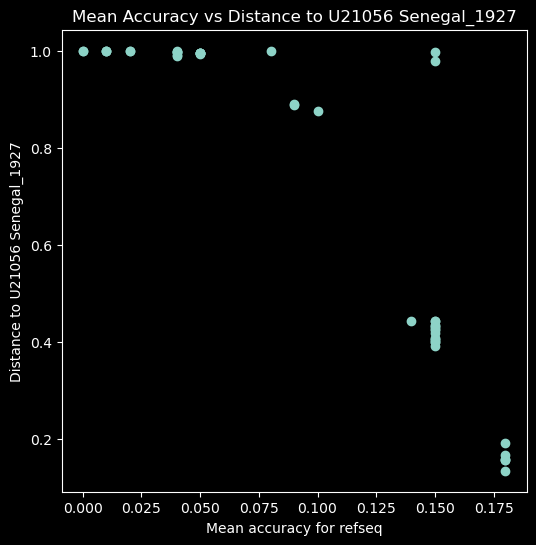

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df_refseqs['distance'], y=df_refseqs['mean acc'])
ax.set_title(f"Mean Accuracy vs Distance to U21056 Senegal_1927")
ax.set_xlabel('Mean accuracy for refseq')
ax.set_ylabel('Distance to U21056 Senegal_1927')
plt.show()

The accuracy is correlated (89%) with the distance between the sequence and U21056, Senegal_1927. 

The only two exeptions are two sequences have a good accuracy (> 90%) and a large distance (0.15):

In [ ]:
df_refseqs.loc[df_refseqs['mean acc'] > 0.5, :].loc[df_refseqs['distance'] > 0.125, :]

,refseq_accession,organism,mean acc,distance
refseqid,,,,
11089:ncbi:67,OM066735,VHF-21-014/GHA/Damongo/2021,0.978810,0.15
11089:ncbi:68,OM066736,VHF-21-029/GHA/Daboya/2021,0.996692,0.15


In [ ]:
df_refseqs.loc[:, ['mean acc', 'distance']].corr()

,mean acc,distance
mean acc,1.000000,-0.894125
distance,-0.894125,1.000000


## Impact of position on accuracy

First we bin `pos_true` into discrete bins. We select the number of bins to include on codon (3 bp)

In [ ]:
nb_bins = refseq_length//6
print(f"{nb_bins:,d} position bins, each bin includes {refseq_length//nb_bins} nucleotides")
df['bin'] = pd.cut(df['pos_true'], bins=nb_bins, labels=range(1,nb_bins+1))
nb_reads_per_position = df.groupby(by='bin')['bin'].count().mean()
print(f"{int(nb_reads_per_position):,d} reads per position bins in average")
df.head(3)

1,706 position bins, each bin includes 6 nucleotides
451 reads per position bins in average


,readid,refseqid,refsource,refseq_strand,taxonomyid,lbl_true,lbl_pred,pos_true,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,preds_score,probs_score,accuracy,bin
0,11089:ncbi:1-17000,11089:ncbi:1,ncbi,-,11089,118,10,7804,0,118,32,10,62,94,0.296598,0.122977,False,1321
1,11089:ncbi:1-16999,11089:ncbi:1,ncbi,-,11089,118,2,6069,4,62,2,32,9,1,-0.024773,0.003527,False,1027
2,11089:ncbi:1-16998,11089:ncbi:1,ncbi,-,11089,118,144,5317,4,144,146,62,118,143,0.090977,0.233104,False,900


In [ ]:
# df_refseqs.loc[:, ['refseq_accession', 'organism']].apply(lambda x,: f"{x[0]} {x[1]}", axis=1)

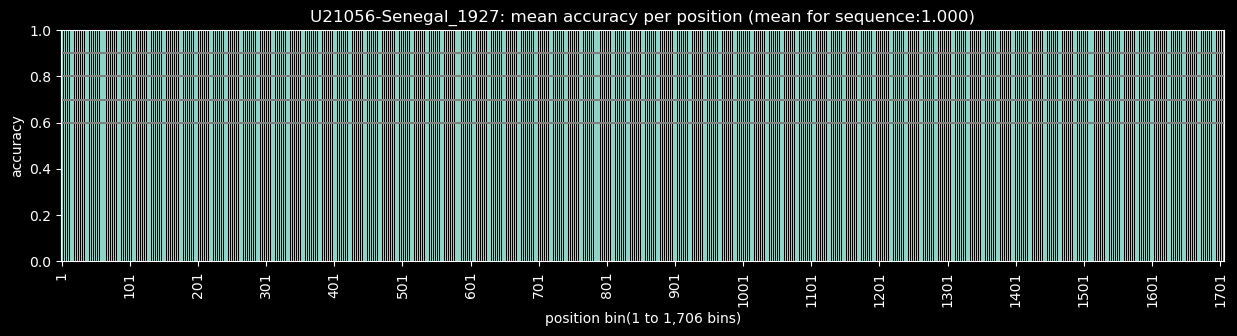

In [ ]:
def plot_accuracy_per_position(df: pd.DataFrame, refseqid:str, figsize=(15,3), ax=None, dense=False):
    df_ = df.loc[df['refseqid'] == refseqid, :]
    n_position_bins = df_.bin.max()
    organism = df_refseqs.loc[:,['refseq_accession', 'organism']].apply(lambda x,: f"{x[0]}-{x[1]}", axis=1).loc[refseqid]
    accuracy = df_['accuracy'].mean()
    acc_per_bin = df_.groupby('bin')['accuracy'].mean()

    if ax is None: 
        fig,ax = plt.subplots(figsize=figsize)
        show_this_axis = True
    else:
        show_this_axis = False
    bar_w = 1 if dense else 0.6
    acc_per_bin.plot(ax=ax, kind='bar', ylim=(0,1), width=bar_w, legend=False)
    ax.set_title(f"{organism}: mean accuracy per position (mean for sequence:{accuracy:.3f})")
    if dense:
        ax.hlines(y=0.5, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid', alpha=0.5)
    else:
        ax.hlines(y=0.6, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.7, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.8, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
        ax.hlines(y=0.9, xmin=0, xmax=n_position_bins, color='gray', linestyles='solid')
    ax.set_xlabel(f"position bin(1 to {nb_bins:,d} bins)")
    ax.set_ylabel('accuracy')
    ax.set_xticks(range(0,n_position_bins,100))

    if show_this_axis: plt.show()

plot_accuracy_per_position(df, '11089:ncbi:6')

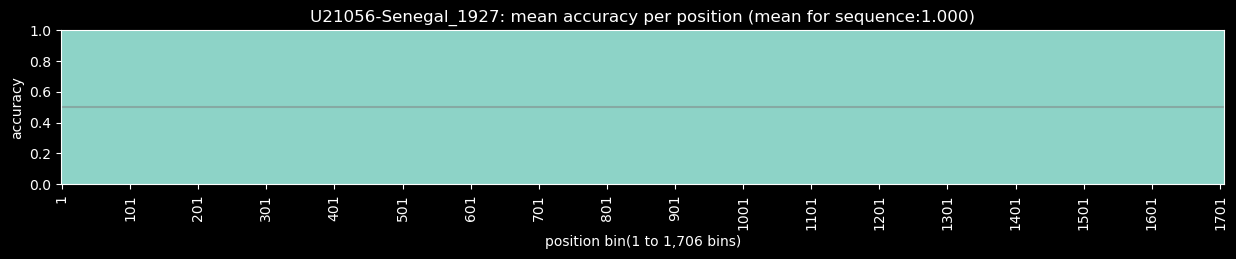

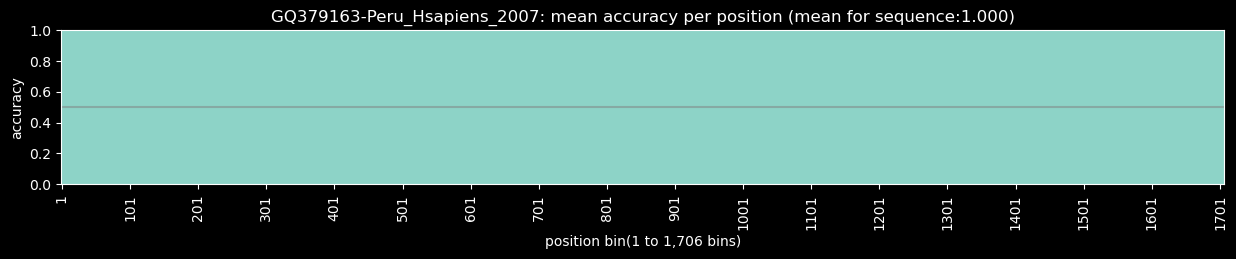

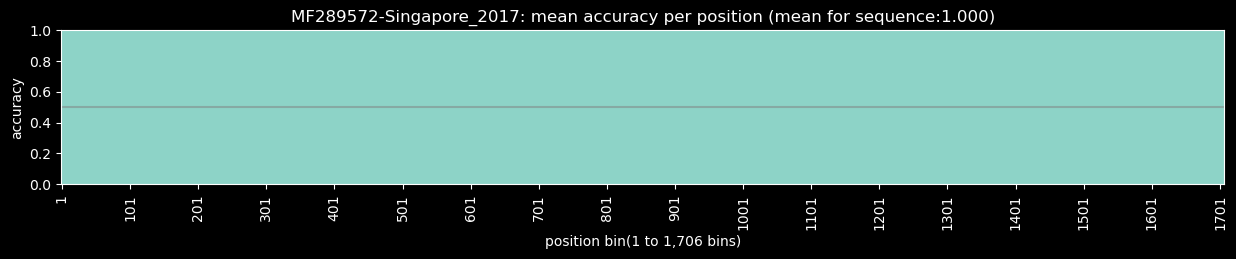

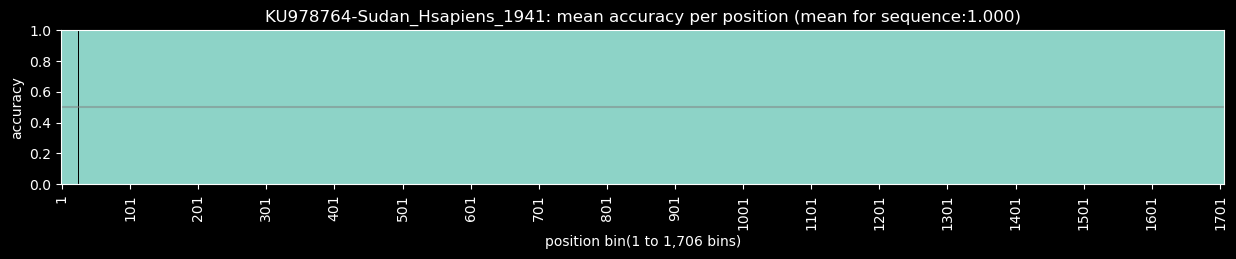

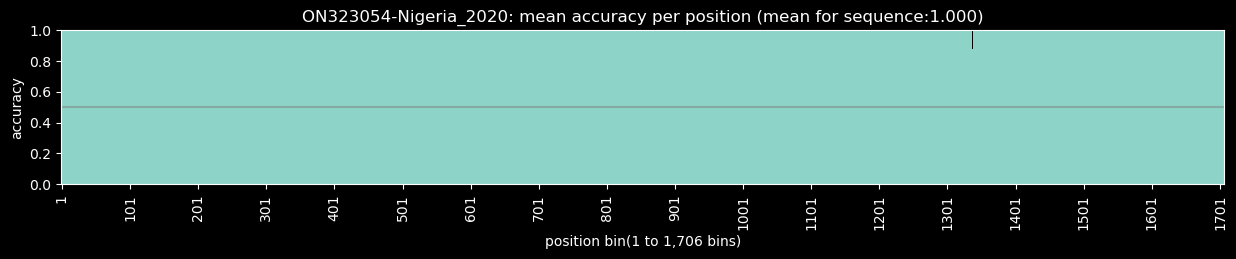

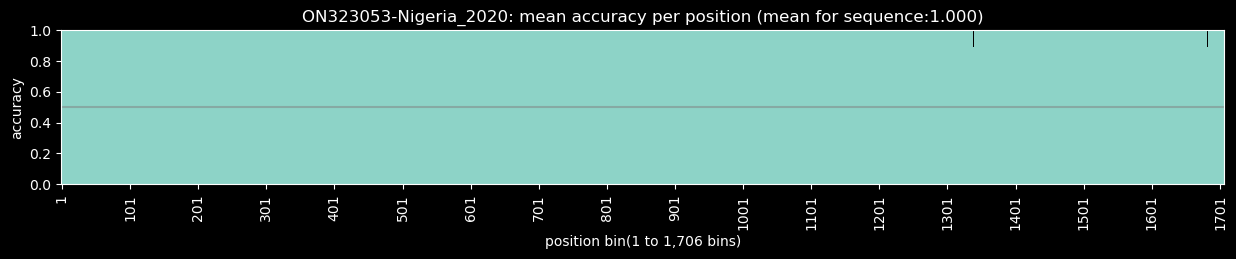

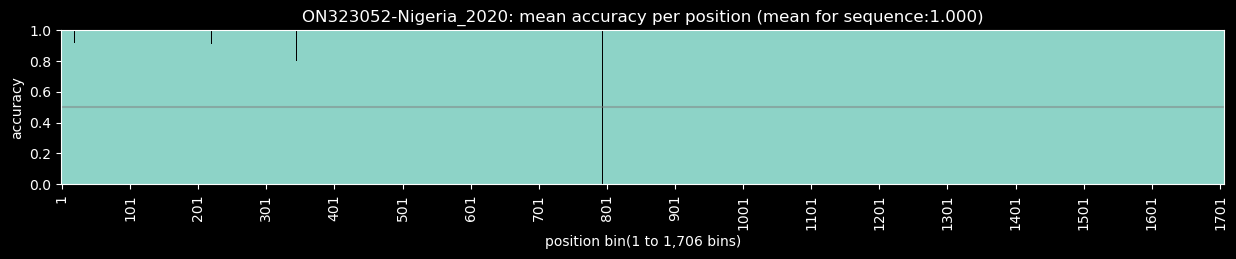

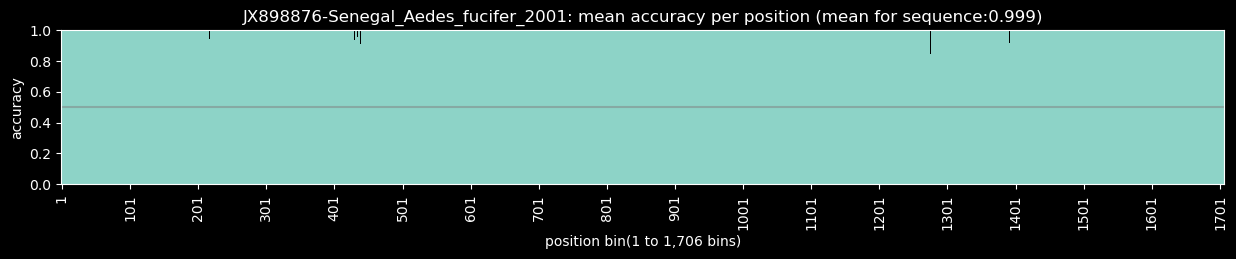

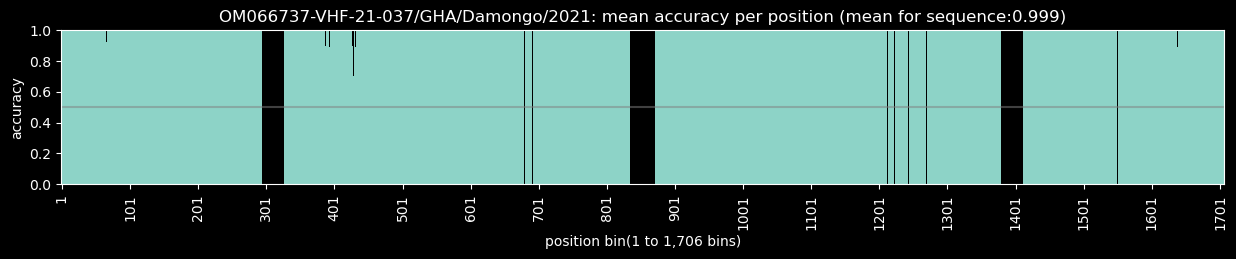

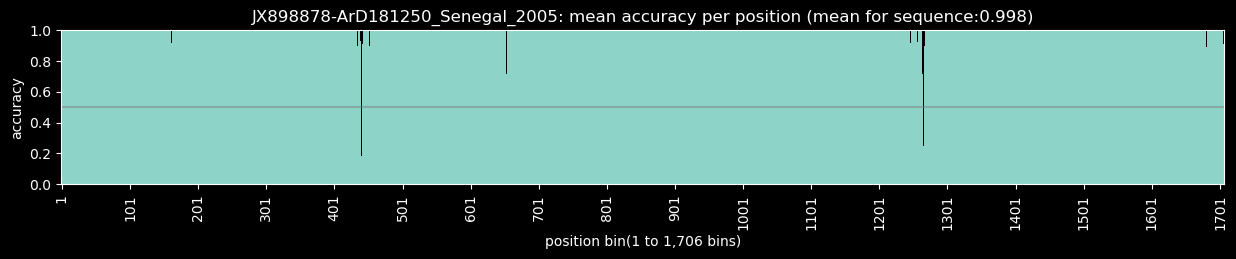

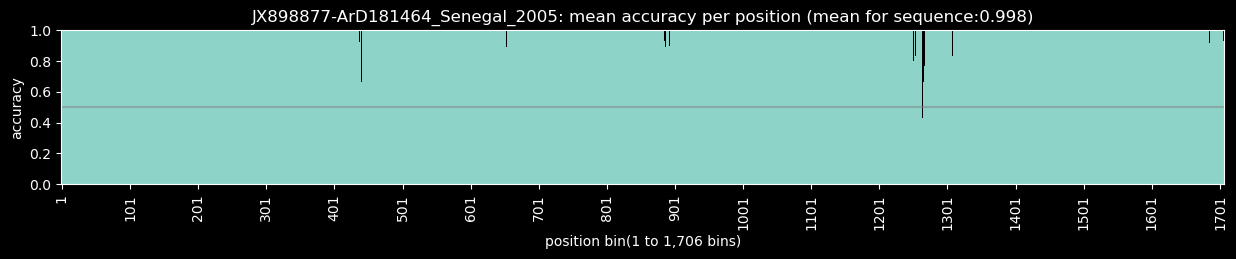

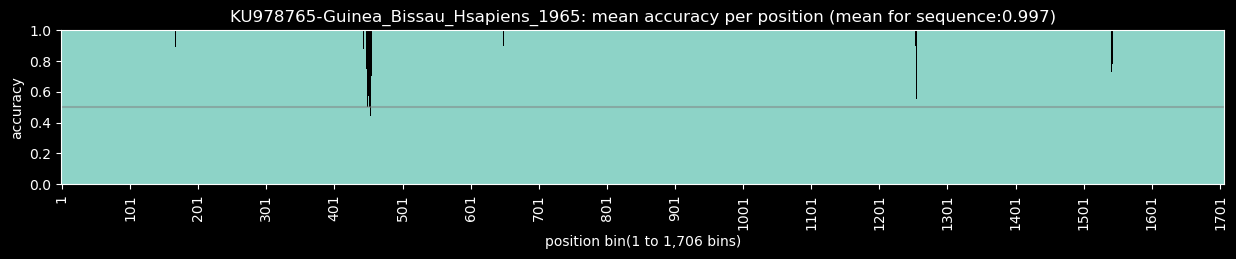

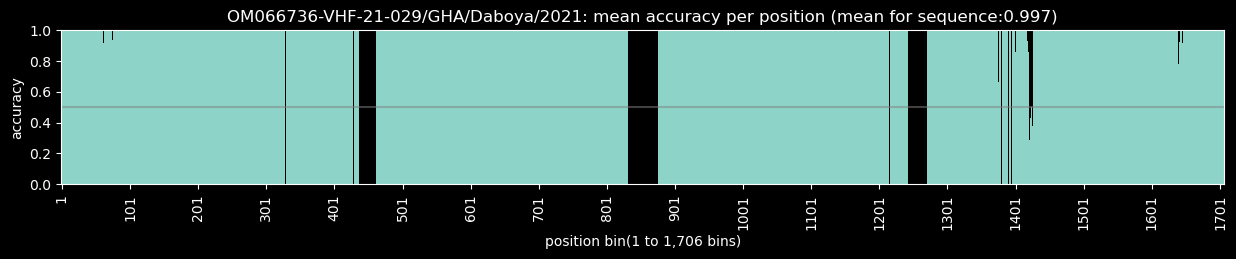

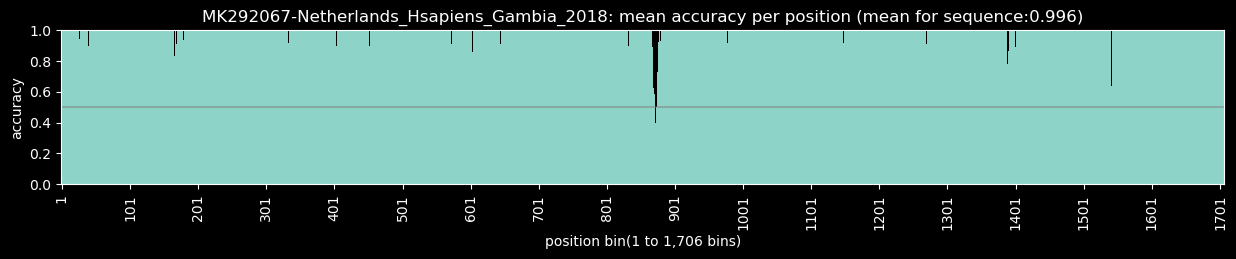

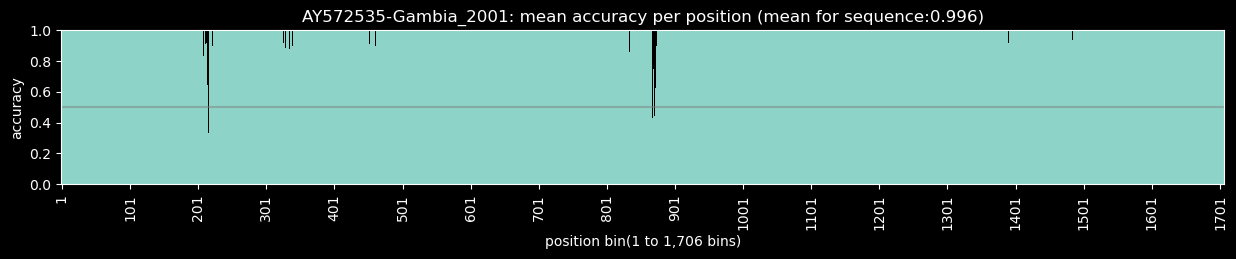

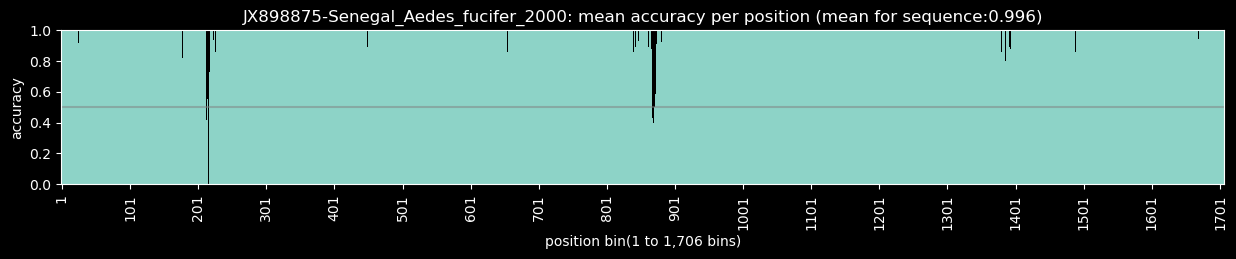

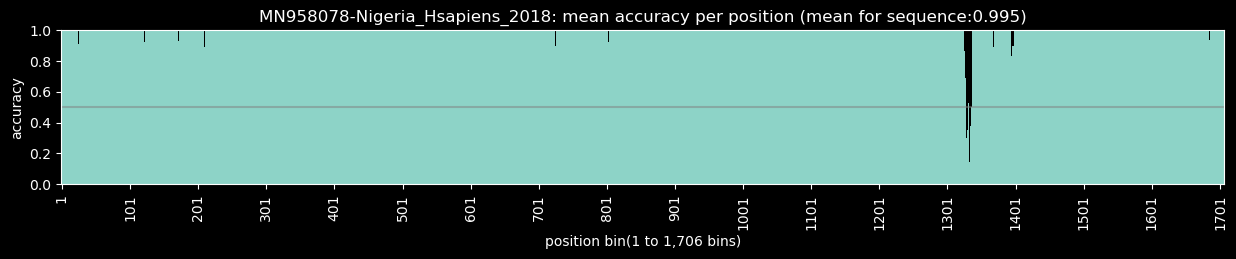

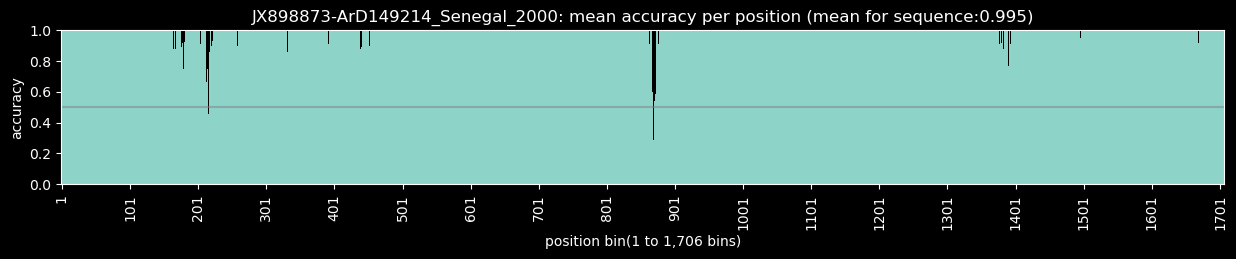

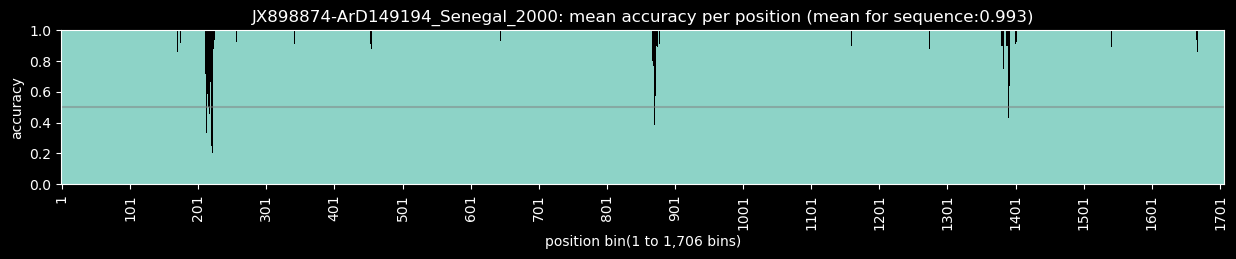

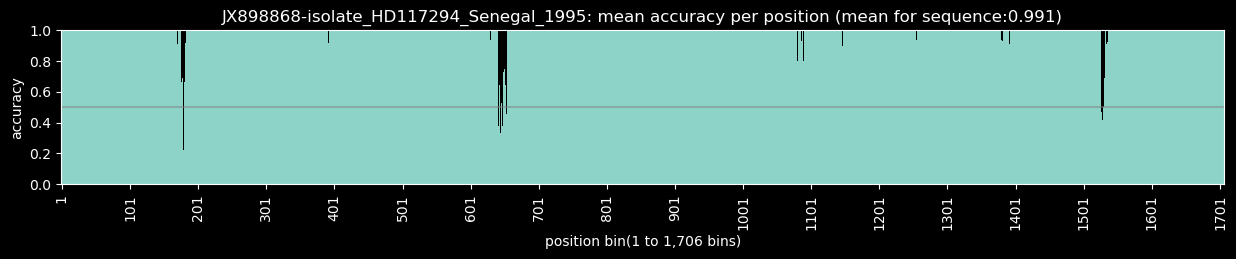

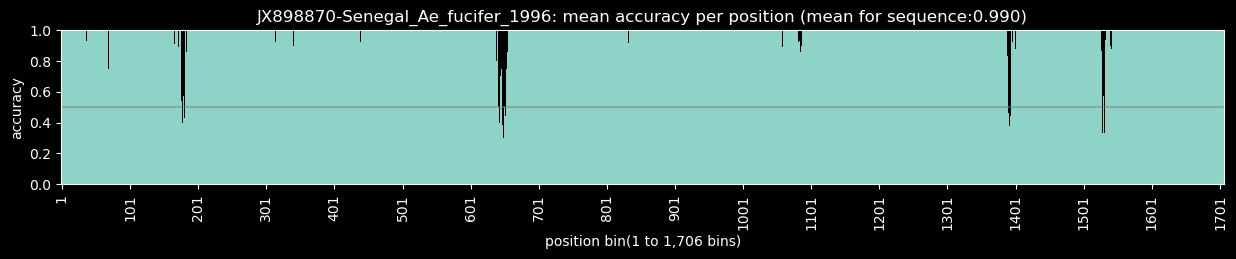

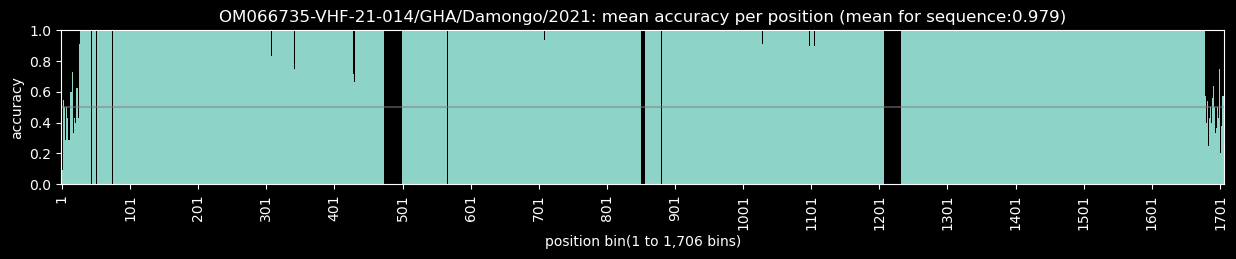

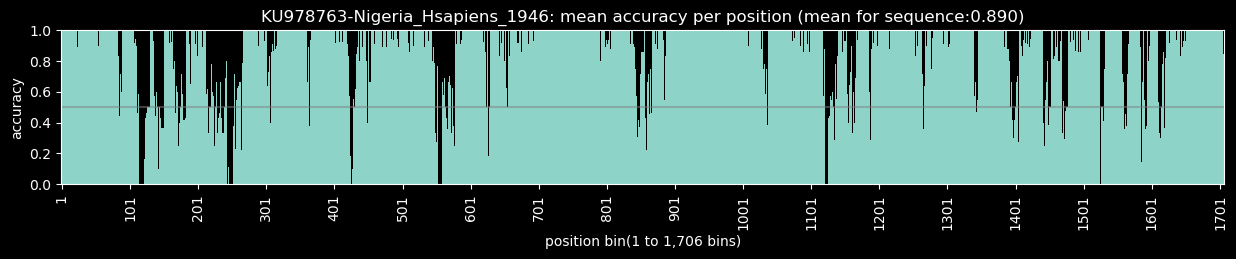

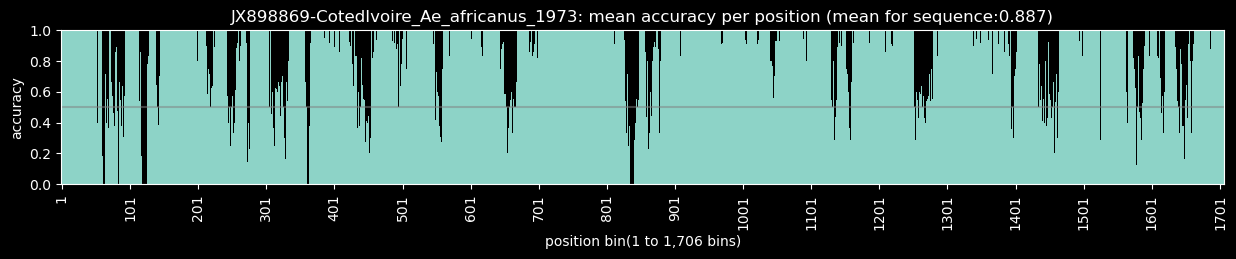

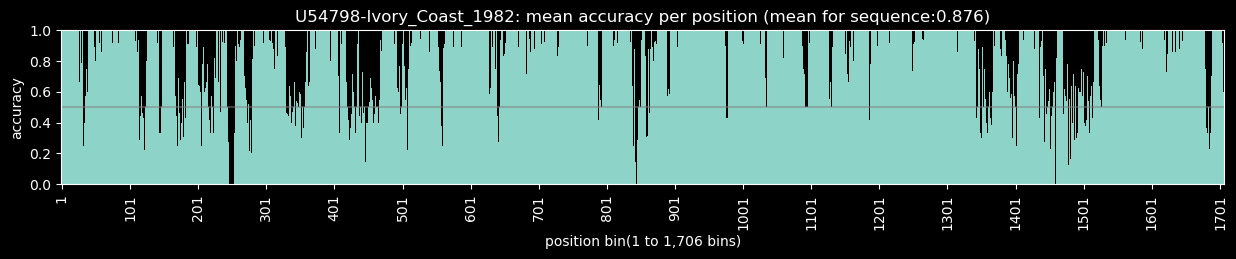

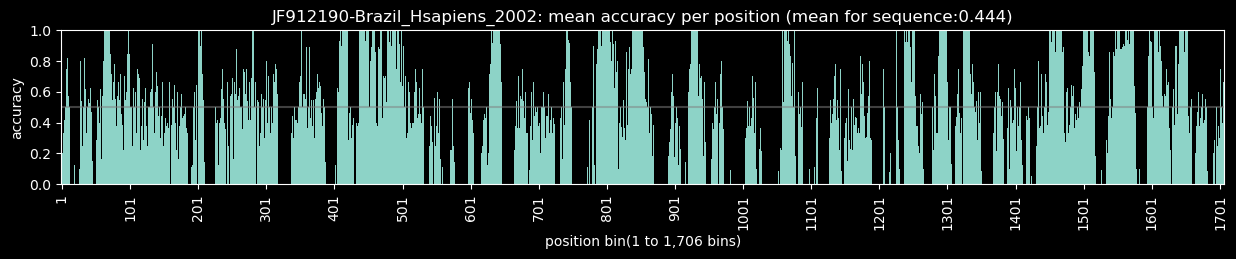

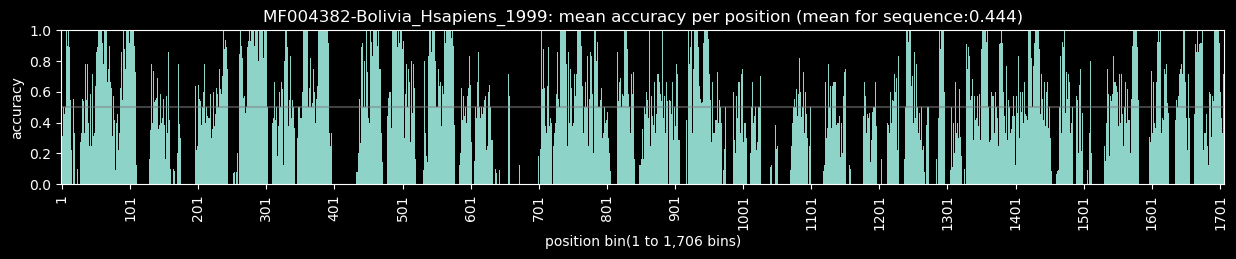

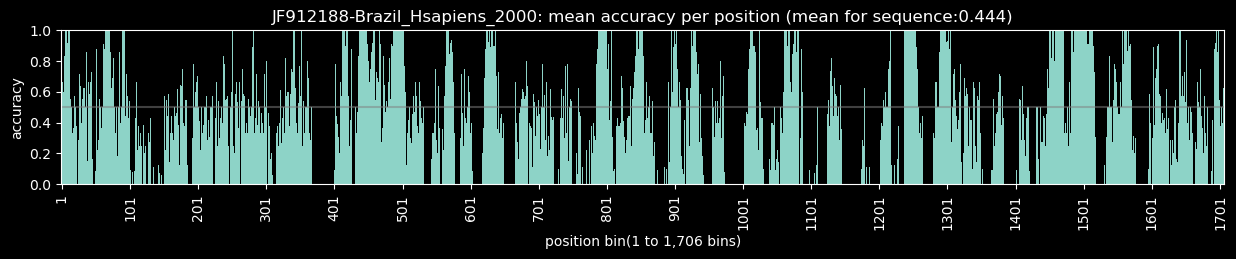

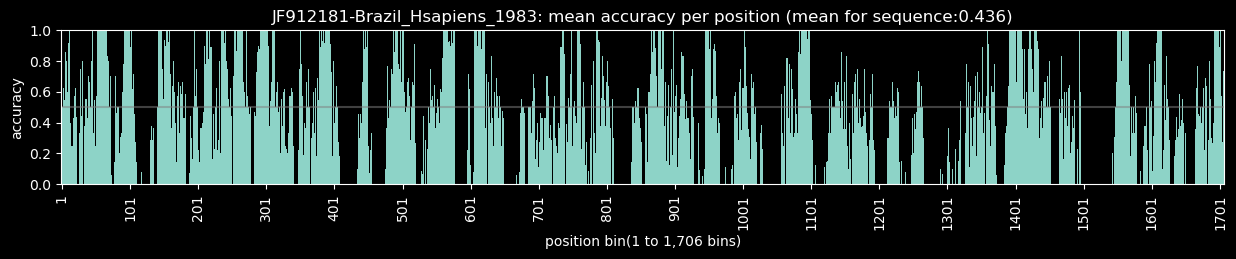

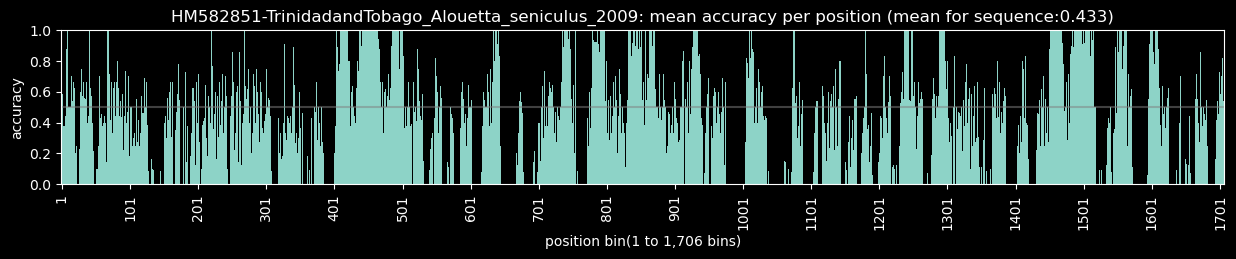

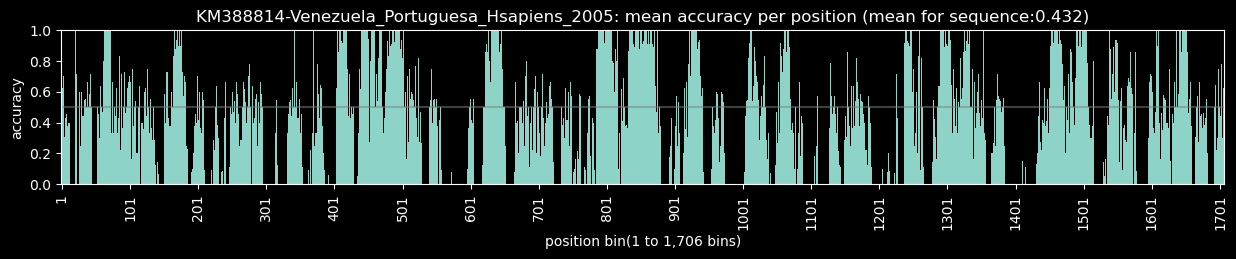

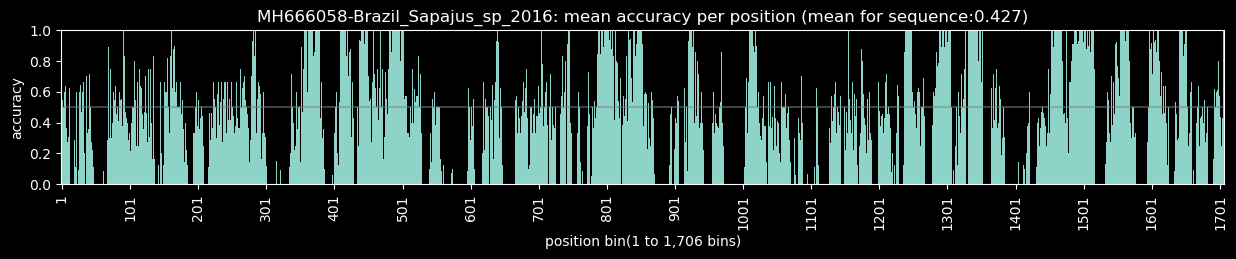

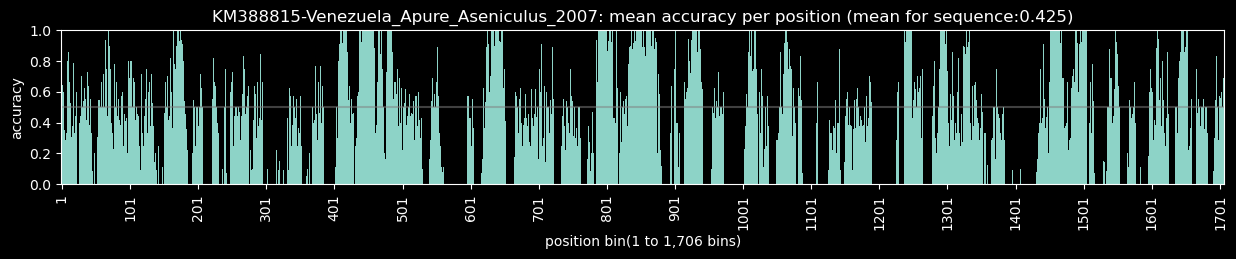

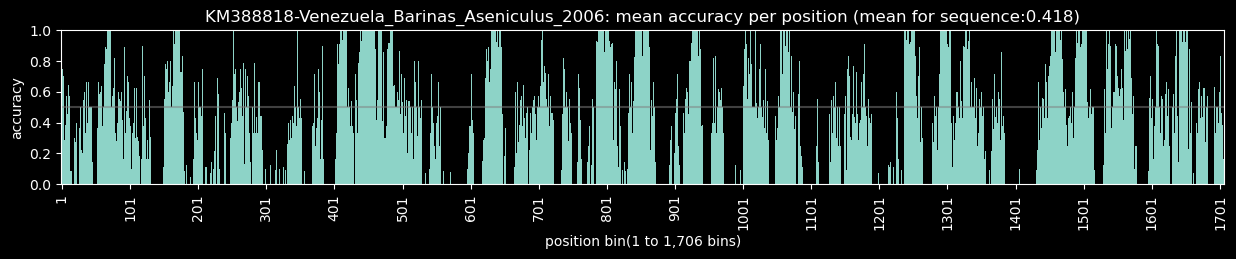

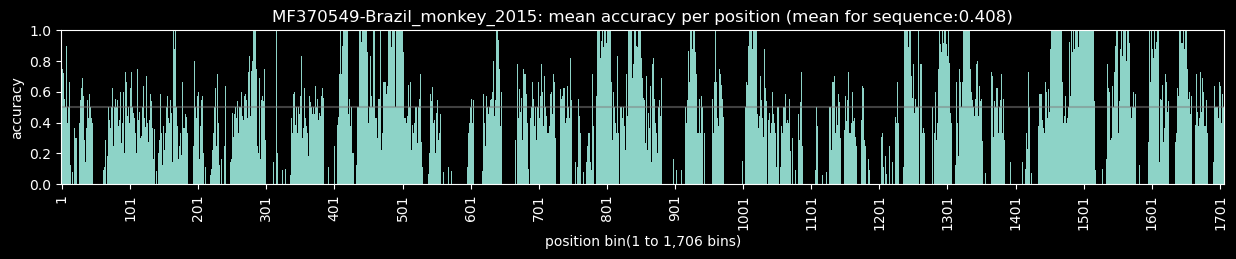

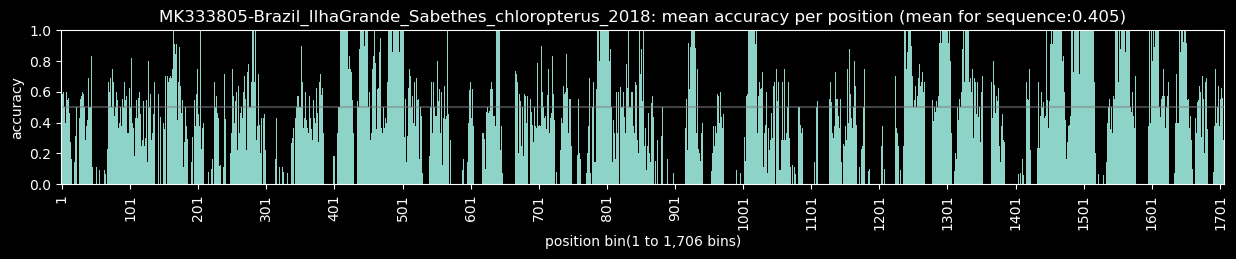

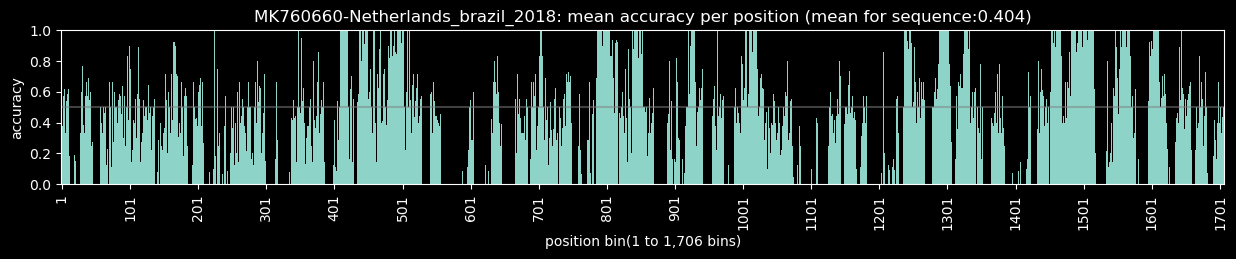

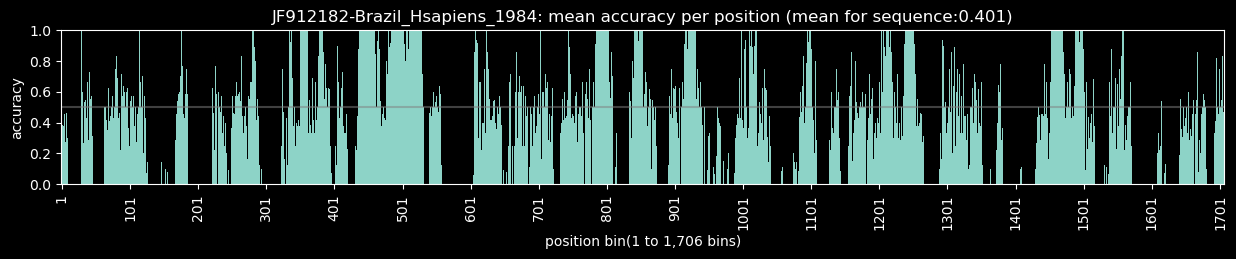

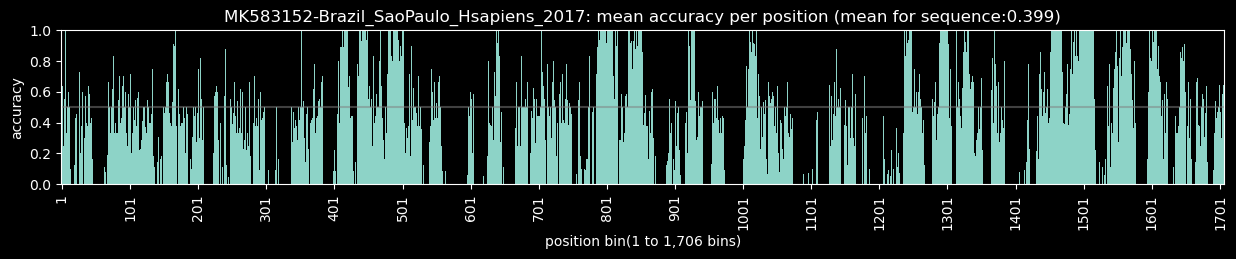

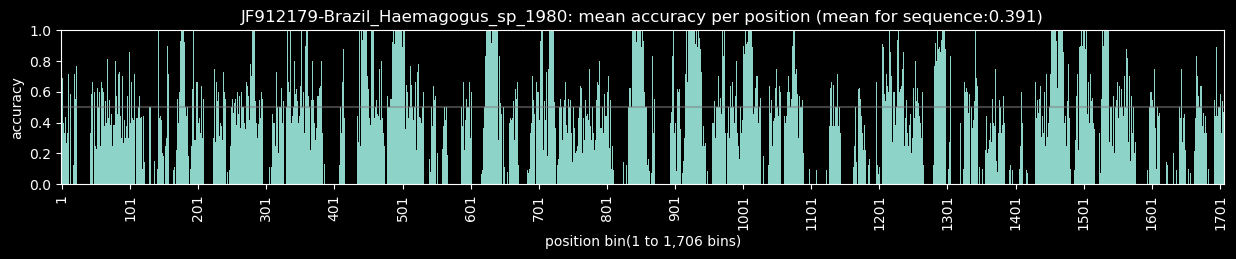

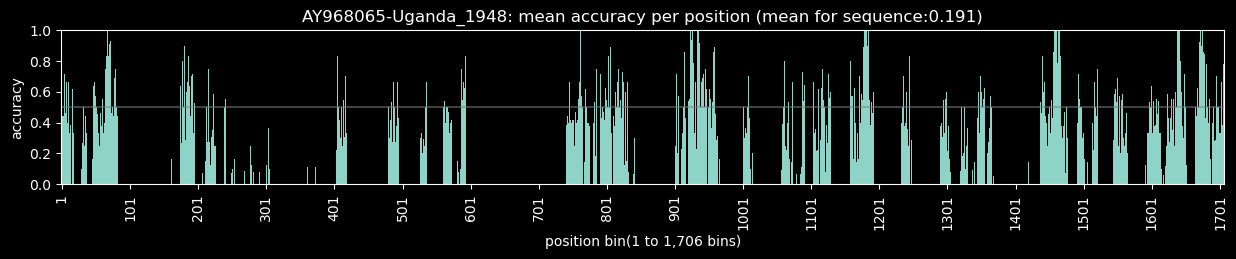

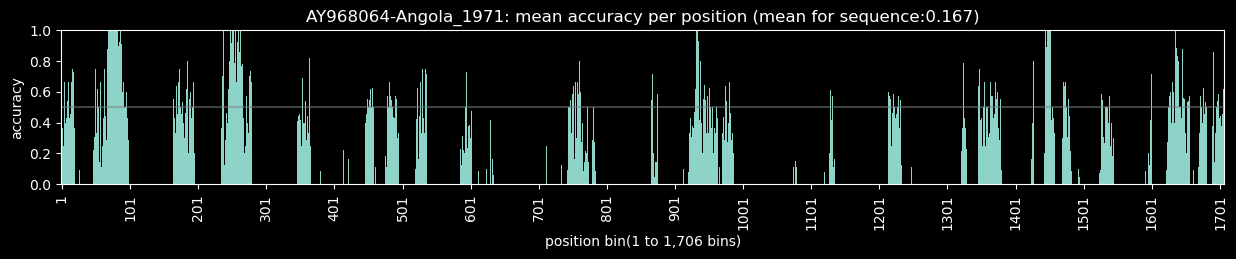

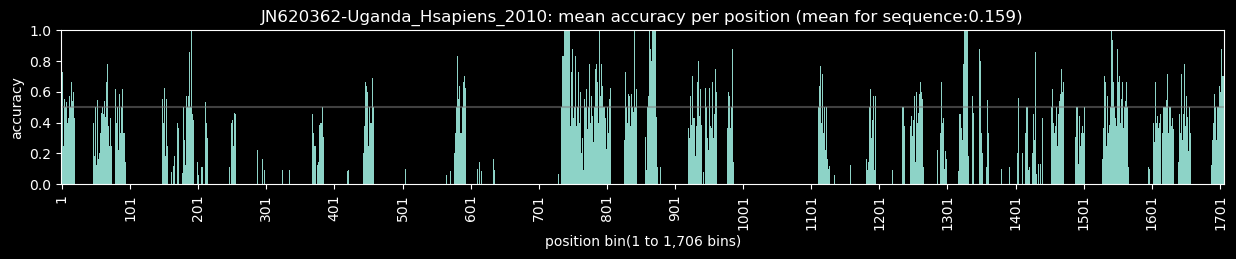

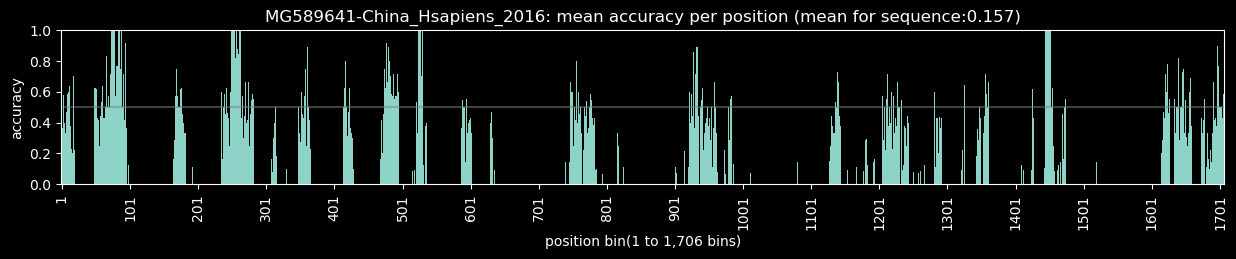

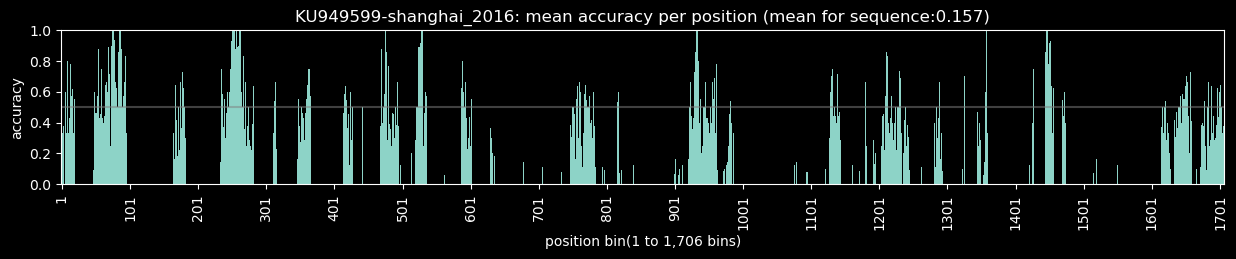

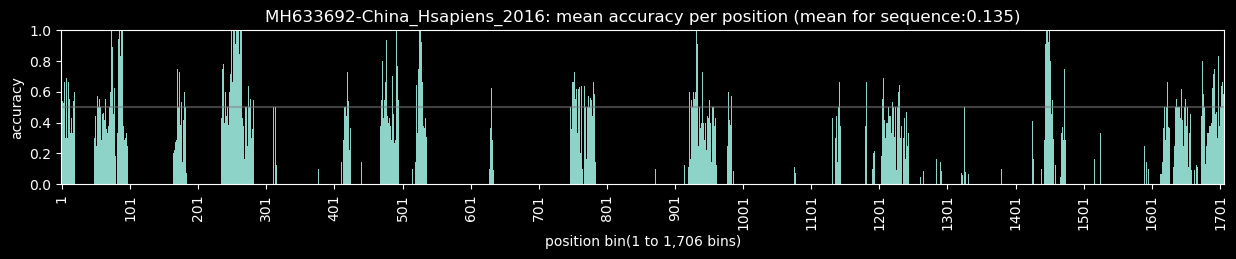

In [ ]:
for idx in ordered_index:
    plot_accuracy_per_position(df, idx, figsize=(15,2), dense=True, ax=None)

In [ ]:
def plot_accuracy(df: pd.DataFrame, figsize=(15,25)):
    # Create a figure and GridSpec object
    fig = plt.figure(figsize=(15, 25))
    fig.suptitle('Accuracy per Reference Sequence and Genome Alignment Positions', fontsize=18)
    nb_refseq = df.shape[0]
    gs = GridSpec(nb_refseq, 3, figure=fig)

    # Create left axes 
    ax_left = fig.add_subplot(gs[0:, 0])
    ax_left.set_title('Acc per refseq')
    plot_accuracy_per_refseq(df, ax=ax_left)
    ax_left.set_title(None)
    ax_left_position = ax_left.get_position()
    left_y1 = ax_left_position.y1
    left_h = ax_left_position.height
    hbar_plot_h = left_h / nb_refseq
    hbar_h = hbar_plot_h * 0.6
    hbar_padding_top = hbar_plot_h * 0.2 

    # Create other subplots
    axs = []
    for i, (refseqid, _) in enumerate(df.sort_values(by='mean_acc', ascending=False).iterrows()):
        ax = fig.add_subplot(gs[i, 1:])
        plot_accuracy_per_position(df, refseqid, ax=ax, dense=True)
        # ovwerwrite axes properties
        if i == nb_refseq-1: 
            ax.set_xlabel('alignment position of read')
        else:
            ax.set_xlabel(None)
            ax.set_xticks([])
            ax.set_xticklabels([])
        ax.set_ylabel(None)
        ax.set_yticks([0, 1])
        ax.set_yticklabels([0,1])
        ax.set_title(None)
            
        ax_pos = ax.get_position()
        ax_y0 = left_y1 - hbar_padding_top - hbar_h - i * hbar_plot_h
        ax.set_position([ax_pos.x0 , ax_y0, ax_pos.width, hbar_h])
        left_title_x = ax_left_position.x0 + ax_left_position.width/2
        right_title_x = ax_pos.x0 + ax_pos.width/2   
        title_y = ax_left_position.y1 - (1-ax_left_position.y1)*.33
        plt.annotate('Accuracy per Reference Sequence', xy=(left_title_x,title_y ), ha='center', xycoords='figure fraction', fontsize=16, color='white')
        plt.annotate('Accuracy per Position', xy=(right_title_x,title_y ), ha='left', xycoords='figure fraction', fontsize=16, color='white')
        axs.append(ax)

    plt.show()

In [ ]:
# for i, _ in enumerate(aln):
#     pass
# print(f"{i:,d}")

## Analysis of Label Probabilities

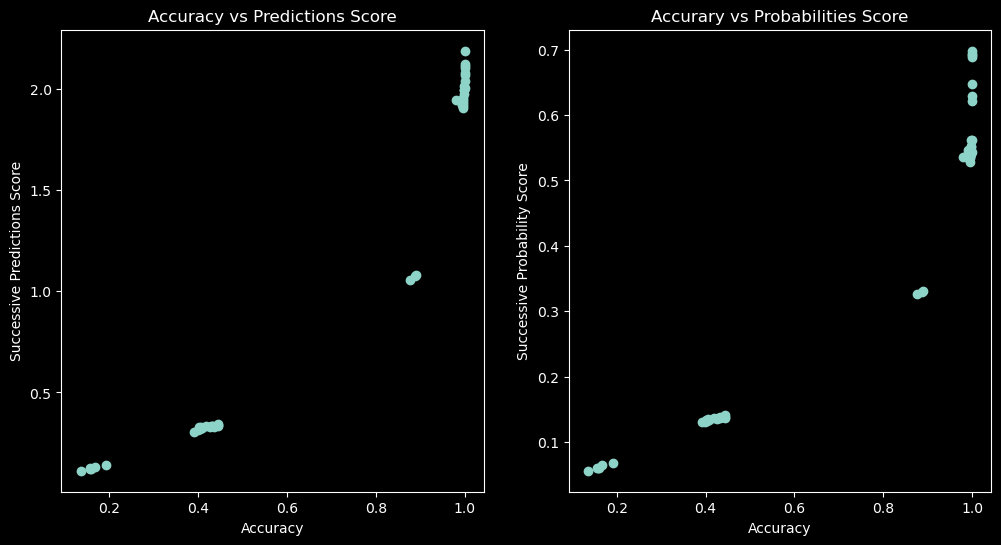

In [ ]:
coi = ['preds_score','probs_score','accuracy']
grouped = df.groupby(by='refseqid')[coi].mean().loc[ordered_index, :]
grouped.index = ordered_distance_index

n = 6
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2 * n, n))
ax1.scatter(x=grouped['accuracy'], y=grouped['preds_score'])
ax1.set_title('Accuracy vs Predictions Score')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Successive Predictions Score')
ax2.scatter(x=grouped['accuracy'], y=grouped['probs_score'])
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Successive Probability Score')
ax2.set_title('Accurary vs Probabilities Score');

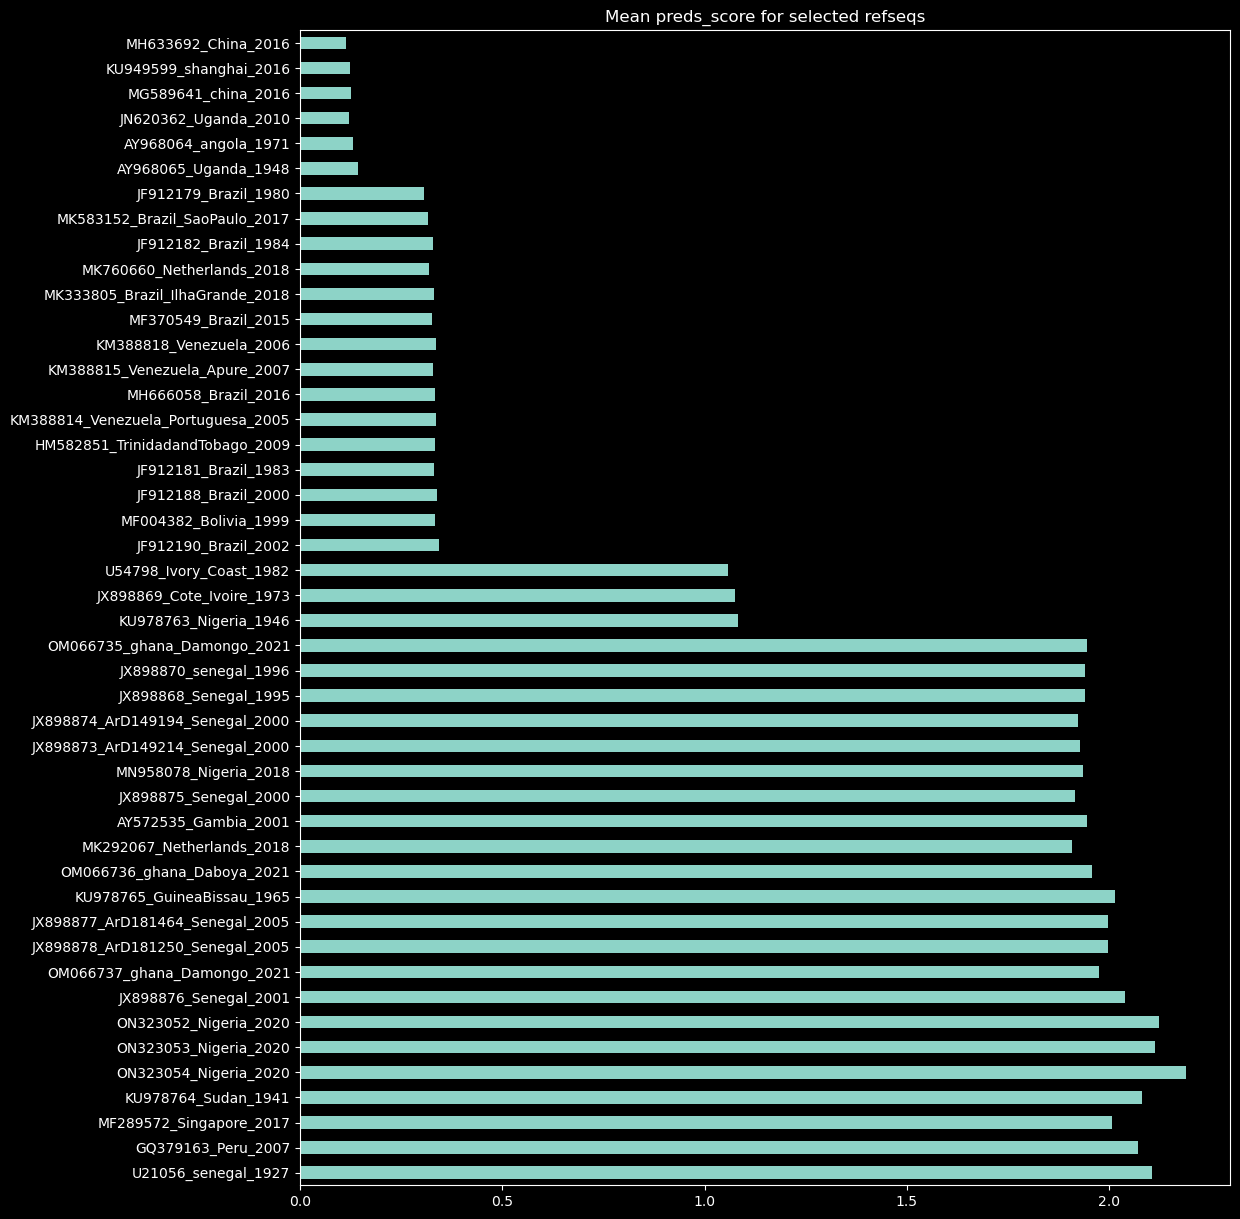

In [ ]:
grouped.preds_score.plot(kind='barh', figsize=(12, 15), title='Mean preds_score for selected refseqs');

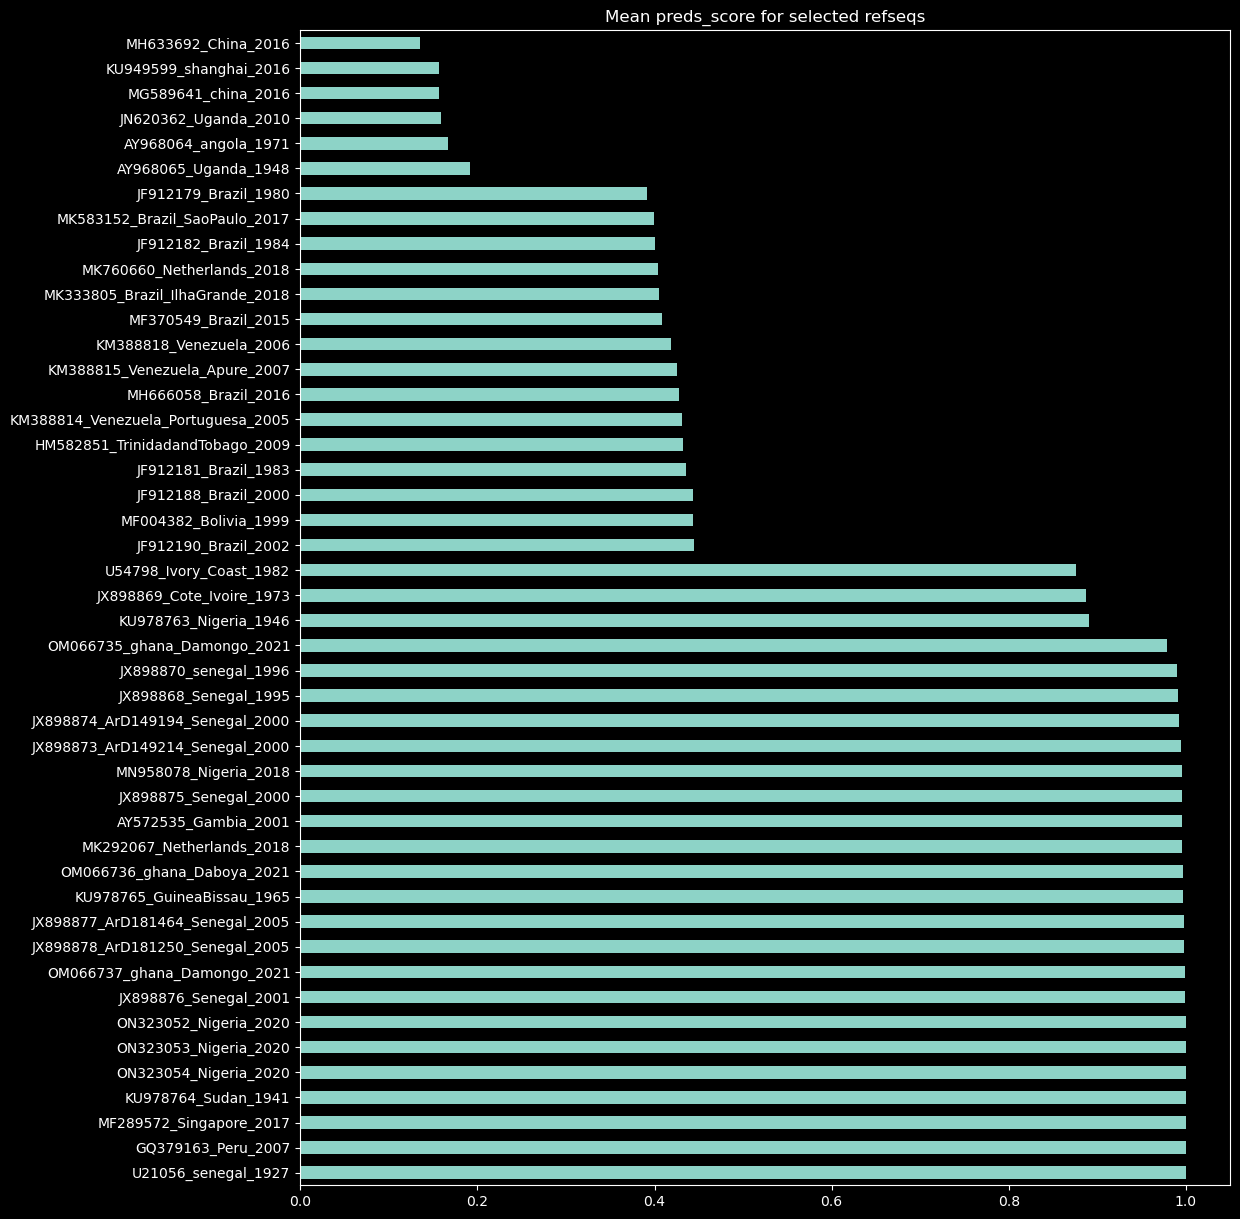

In [ ]:
grouped.accuracy.plot(kind='barh', figsize=(12, 15), title='Mean preds_score for selected refseqs');

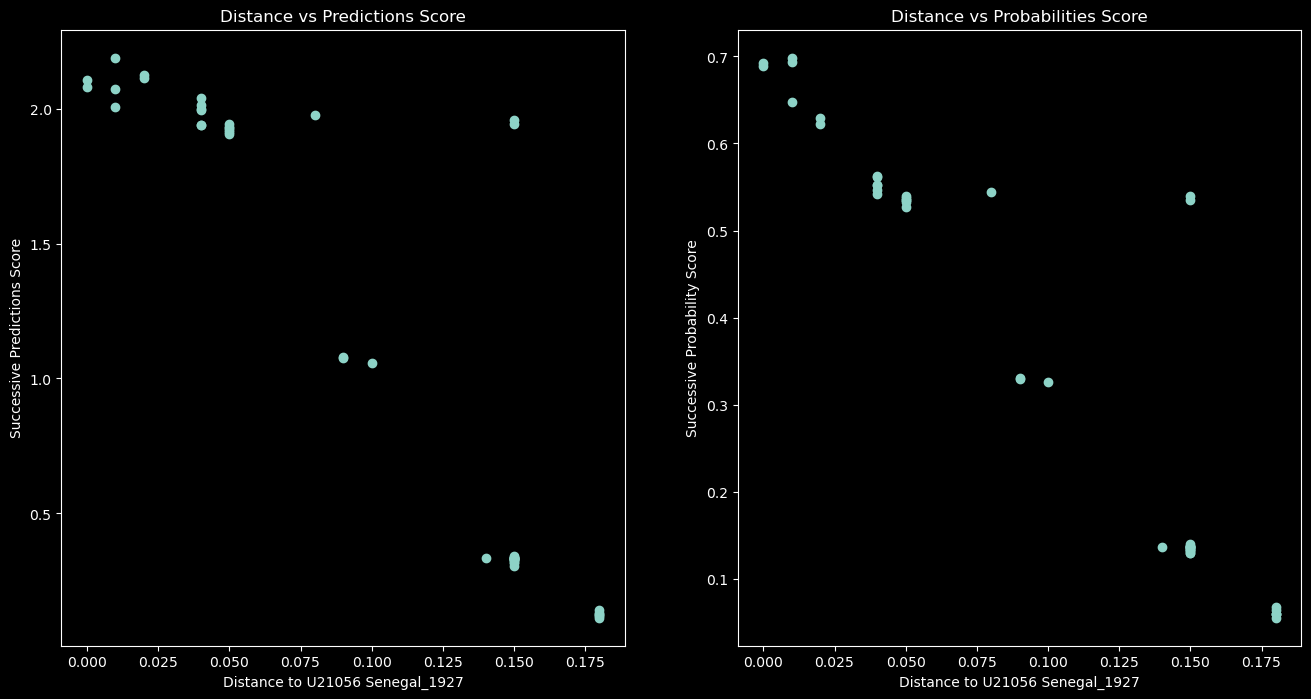

In [ ]:
n = 8
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2 * n, n))
ax1.scatter(x=distances.loc[ordered_distance_index], y=grouped['preds_score']);
ax1.set_title('Distance vs Predictions Score')
ax1.set_xlabel('Distance to U21056 Senegal_1927')
ax1.set_ylabel('Successive Predictions Score')
ax2.scatter(x=distances.loc[ordered_distance_index], y=grouped['probs_score']);
ax2.set_title('Distance vs Probabilities Score')
ax2.set_xlabel('Distance to U21056 Senegal_1927')
ax2.set_ylabel('Successive Probability Score');


### Probability per position

In [ ]:
grouped = df.groupby(by=['refseqid','bin'])[['preds_score','probs_score','accuracy']].mean()
grouped.loc['11089:ncbi:6', slice(None), :]

,preds_score,probs_score,accuracy
bin,,,
1,2.119026,0.662537,1.0
2,2.450612,0.688406,1.0
3,2.131460,0.687190,1.0
4,2.150444,0.685324,1.0
5,2.261253,0.694410,1.0
...,...,...,...
1702,2.341593,0.703431,1.0
1703,2.000419,0.656283,1.0
1704,1.919379,0.668221,1.0


# Sandbox

## Experimenting how to query the database for probabilities

In [ ]:
%%time
# Retrieve three columns filtering on a list of id
# CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
# Wall time: 3.03 s
query = f"""
SELECT id, read_kmer_id, read_50mer_nb
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20_000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

In [ ]:
%%time
# Retrieve three columns filtering on a list of id
# CPU times: user 86.4 ms, sys: 27.7 ms, total: 114 ms
# Wall time: 3.03 s

query = f"""
SELECT id, read_kmer_id, read_50mer_nb
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20_000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

In [ ]:
%%time
# Retrieve all colomns filtering on a list of id
# CPU times: user 146 ms, sys: 33.2 ms, total: 179 ms
# Wall time: 3.69 s
query = f"""
SELECT *
FROM label_probabilities 
WHERE id IN ({','.join([str(x) for x in range(20000)])})
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail(5))

In [ ]:
%%time
# Retrieve 4 columns filtering on a specific read_kmer_id
# CPU times: user 25.1 ms, sys: 15.3 ms, total: 40.4 ms
# Wall time: 1.61 s

# id, read_kmer_id, read_50mer_nb, prob_001
query = f"""
SELECT id, read_kmer_id, read_50mer_nb, prob_001
FROM label_probabilities 
WHERE read_kmer_id = '11089:ncbi:1-1'
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail())

In [ ]:
%%time
# Retrieve 4 columns filtering on a list of read_kmer_id
# CPU times: user 54.8 ms, sys: 10.1 ms, total: 64.9 ms
# Wall time: 1.82 s

# id, read_kmer_id, read_50mer_nb, prob_001
query = f"""
SELECT id, read_kmer_id, read_50mer_nb, prob_001
FROM label_probabilities 
WHERE read_kmer_id IN ('11089:ncbi:1-1', '11089:ncbi:1-2', '11089:ncbi:1-3', '11089:ncbi:1-4')
LIMIT 1000 ;
"""
# print(query)
df_probs = db.get_dataframe(query)

print(df_probs.shape)
display(df_probs.tail())

List all indexes in the database

In [ ]:
db.list_indexes()

Creating a view to combine `predictions` and `label_probabilities`

In [ ]:
def create_view_preds_probs(self):
    
    # Create view joining predictions and label_probabilities
    view_name = 'preds_probs'

    # top prediction columns from table predictions:
    top_lbl_pred_n = ','.join([f"p.top_5_lbl_pred_{i}" for i in range(5)])
    print(top_lbl_pred_n)

    # probabilities columns from table label_probabilities 
    probs_n = ','.join([f"lp.prob_{i:03d}" for i in range(187)])

    query = f"""
    CREATE VIEW IF NOT EXISTS {view_name} AS
    SELECT 
        lp.id,
        p.refseqid,
        p.lbl_true, p.lbl_pred,
        p.pos_true, p.pos_pred,
        {top_lbl_pred_n},
        lp.read_kmer_id, lp.read_50mer_nb,
        {probs_n}
    FROM 
        label_probabilities lp
    INNER JOIN 
        predictions p
    ON 
        lp.read_kmer_id = p.readid
    """
    print(query)
    self.execute(query)

def drop_view_preds_probs(self):
    
    self.execute('DROP VIEW IF EXISTS preds_probs')
    
# drop_view_preds_probs(db)
# create_view_preds_probs(db)
# db.print_schema()


- 1 refseqid -> 17,000 read_kmer_id
- 1 read_kmer_id -> 101 read_50mer_nb
- 1 refseqid -> 1,717,000 read_50mer_nb

If we read in pages of 200 read_kmer_id:
- 1 refseqid -> 85 pages of 200 read_kmer_id
- 1 page of 200 read_kmer_id -> 20,200 read_50mer_nb
- each page will take about 20,200 * 3.5 ms = 70 sec

If we read in pages of 250 read_kmer_id:
- 1 refseqid -> 68 pages of 250 read_kmer_id
- 1 page of 250 read_kmer_id -> 25,250 read_50mer_nb
- each page will take about 25,250 * 3.5 ms = 88 sec

|# read_50mer_nb|wall time|wall time per row|
|---:|:---:|:---:|
|1,000|6 sec|6 ms|
|10,000|35 sec|3.5 ms|
|25,250|1 min 23 sec| 3.3 ms|
|50,000|2 min 57 sec| 3.5 ms|
|100,000|6 min 11 sec | 3.6 ms|

Seems that the page size of 25,250 is a good comprimise between speed and number of queries.


## Distance Matrix

In [ ]:
p2matrix = pfs.data / 'ncbi/other/yf/YF_2023_envelop_percentage_distance_matrix.csv'
dist_mx = pd.read_csv(p2matrix, index_col=0)
for col in dist_mx.columns:
    dist_mx[col] = dist_mx[col].str.rstrip('%').astype(float)/100
dist_mx

,YFV_Cameroon_2023,YFV_CAR_2019,U21056_senegal_1927,JX898870_senegal_1996,U23574_Senegal_1965,JX898868_Senegal_1995,JX898873_ArD149214_Senegal_2000,JX898874_ArD149194_Senegal_2000,JX898875_Senegal_2000,JX898876_Senegal_2001,...,MH666058_Brazil_2016,MF370547_Brazil_2017,MK583152_Brazil_SaoPaulo_2017,KY885001_Brazil_2017,MW308134_Brazil_2018,MK760660_Netherlands_2018,MK333805_Brazil_IlhaGrande_2018,MW308135_Brazil_2019,MZ604867_Brazil_2019,MZ712143_Brazil_2021
,,,,,,,,,,,,,,,,,,,,,
YFV_Cameroon_2023,0.00,0.04,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,...,0.19,0.18,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
YFV_CAR_2019,0.04,0.00,0.19,0.18,0.18,0.18,0.18,0.18,0.18,0.18,...,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
U21056_senegal_1927,0.19,0.19,0.00,0.04,0.04,0.04,0.05,0.05,0.05,0.04,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
JX898870_senegal_1996,0.19,0.18,0.04,0.00,0.03,0.00,0.03,0.03,0.03,0.03,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
U23574_Senegal_1965,0.19,0.18,0.04,0.03,0.00,0.03,0.04,0.04,0.04,0.03,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK760660_Netherlands_2018,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MK333805_Brazil_IlhaGrande_2018,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MW308135_Brazil_2019,0.19,0.19,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Extract sequences accession from the distance matrix

In [ ]:
distance_accessions = {}
missing=[]
for col in dist_mx.columns:
    regex = re.compile(r'^(?P<accession>\w{1,2}\d*)_(?P<country>.*)_(?P<year>\d\d\d\d)$')
    match = regex.search(col)
    if match: 
        accession = match.group('accession')
        subdict = {
            'accession': accession, 
            'country': match.group('country'), 
            'year': match.group('year'),
            'definition line': col
            } 
        distance_accessions[accession] = subdict
    else:
        missing =+ 1
        print(col, 'could not find the accession')

distance_accessions['U21056']

YFV_Cameroon_2023 could not find the accession
YFV_CAR_2019 could not find the accession
Yellow_fever_YF118_CAR_2018 could not find the accession


{'accession': 'U21056',
 'country': 'senegal',
 'year': '1927',
 'definition line': 'U21056_senegal_1927'}

In [ ]:
for refseqid in df_refseqs.index:
    accession = df_refseqs.loc[refseqid, 'refseq_accession']
    print(accession, refseqid, distance_accessions.get(accession, 'not found')['definition line'])

AY968064 11089:ncbi:1 AY968064_angola_1971
U54798 11089:ncbi:2 U54798_Ivory_Coast_1982
AY572535 11089:ncbi:4 AY572535_Gambia_2001
U21056 11089:ncbi:6 U21056_senegal_1927
AY968065 11089:ncbi:7 AY968065_Uganda_1948
GQ379163 11089:ncbi:10 GQ379163_Peru_2007
MF289572 11089:ncbi:12 MF289572_Singapore_2017
KU978764 11089:ncbi:13 KU978764_Sudan_1941
JX898878 11089:ncbi:14 JX898878_ArD181250_Senegal_2005
JX898877 11089:ncbi:18 JX898877_ArD181464_Senegal_2005
JX898876 11089:ncbi:19 JX898876_Senegal_2001
KU978765 11089:ncbi:20 KU978765_GuineaBissau_1965
JX898870 11089:ncbi:21 JX898870_senegal_1996
JX898868 11089:ncbi:22 JX898868_Senegal_1995
JX898875 11089:ncbi:23 JX898875_Senegal_2000
JX898874 11089:ncbi:24 JX898874_ArD149194_Senegal_2000
JX898873 11089:ncbi:25 JX898873_ArD149214_Senegal_2000
MK292067 11089:ncbi:26 MK292067_Netherlands_2018
MN958078 11089:ncbi:28 MN958078_Nigeria_2018
JX898869 11089:ncbi:29 JX898869_Cote_Ivoire_1973
KU978763 11089:ncbi:30 KU978763_Nigeria_1946
MF004382 11089:nc

In [ ]:
file_stem = 'single_69seq_150bp'

p2aln = pfs.data / f"ncbi/simreads/yf/{file_stem[:-2] if file_stem[-1] in ['1', '2'] else file_stem}/{file_stem}.aln"
assert p2aln.exists()
aln = AlnFileReader(p2aln)
refseq_metadata = aln.parse_header_reference_sequences()
refseq_metadata['11089:ncbi:1']

{'organism': 'Angola_1971',
 'refseq_accession': 'AY968064',
 'refseq_length': '10237',
 'refseqid': '11089:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '11089'}

In [ ]:
for selected in selected_refseqs:
    accession = refseq_metadata[selected]['refseq_accession']
    print(f"{selected:14s}    {refseq_metadata[selected]['organism']:25s}    {refseq_metadata[selected]['refseq_accession']:20s}   {distance_accessions[accession]['definition line']:30s}")

In [ ]:
refseqid2dist_mx_idx = {}
dist_mx_idx2refseqid = {}

for refseqid in selected_refseqs:
    accession = refseq_metadata[refseqid]['refseq_accession']
    idx = distance_accessions[accession]['definition line']
    refseqid2dist_mx_idx[refseqid] = idx
    dist_mx_idx2refseqid[idx] = refseqid

selected_dist_idxs = [refseqid2dist_mx_idx[rsid] for rsid in selected_refseqs]
selected_dist = dist_mx.loc[selected_dist_idxs, selected_dist_idxs]
selected_dist.index=selected_refseqs
selected_dist.columns=selected_refseqs
sns.heatmap(selected_dist, cmap='cividis', annot=True, vmin=0, vmax=0.5);

Accuracy vs Distance

In [ ]:
%%time
df_reads = db.get_dataframe('SELECT id, refseqid, lbl_true, lbl_pred, pos_true FROM predictions')
df_reads.shape

In [ ]:
df_reads['accuracy'] = df_reads.lbl_pred == df_reads.lbl_true

In [ ]:
bins = [0 + n * 10237/n_position_bins for n in range(n_position_bins+1)]
df_reads['pos_bin'] = pd.cut(df_reads['pos_true'], bins, retbins=False)
df_reads['pos_bin'].cat.categories = range(1, n_position_bins+1) # rename categories from 1 to n_position_bins

In [ ]:
df_reads.head()

In [ ]:
r_group = df_reads.groupby('refseqid')
r_acc_sum = r_group['accuracy'].sum()
r_counts = r_group['accuracy'].count().replace(0,1)
r_acc_mean = r_acc_sum.div(r_counts)
# display(r_acc_mean)

bin_group = df_reads.groupby(['refseqid','pos_bin'])
bin_acc_mean = bin_group.mean().loc[(slice(None),slice(None)), ['accuracy']]
# bin_acc_mean

In [ ]:
set(selected_dist.index).difference(set(selected_refseqs))

In [ ]:
common_refseqid = list(set(df_reads.refseqid.unique()).intersection(set(selected_refseqs)))

In [ ]:
plt.scatter(x=selected_dist.loc[common_refseqid[2], common_refseqid], y=r_acc_mean.loc[common_refseqid]);

## Successive predictions

#### Successive identical predictions (integer)

To evaluate and compare multiple lists of integers based on the criteria you've described, you can use a custom scoring function that takes into account both the number of elements equal to the given value y and the length of sequences of identical elements. Here's a suggested approach using a mathematical function as a metric:

Proposed Scoring Function

Let's define a scoring function S(L, y) for a list L and target value y:
```
S(L, y) = (C / N) * (1 + (M / N) * (1 - F / C))
```
Where:
- N is the total number of elements in the list
- C is the count of elements equal to y
- M is the maximum length of any continuous sequence of y in the list
- F is the number of "fragments" or separate sequences of y in the list

Explanation of the Function Components

1. (C / N): This represents the proportion of elements in the list that are equal to y. It ranges from 0 to 1.

2. (1 + (M / N) * (1 - F / C)): This factor rewards longer sequences and penalizes fragmentation.
   - (M / N) rewards longer continuous sequences of y
   - (1 - F / C) penalizes fragmentation; it's 1 when there's only one sequence (F = 1) and decreases as the number of fragments increases

Properties of the Scoring Function

1. The score will be highest (1.0) when all elements are equal to y (C = N, M = N, F = 1).
2. For the same number of matching elements (C), lists with longer continuous sequences will score higher.
3. For the same number of matching elements (C) and maximum sequence length (M), lists with fewer fragments will score higher.

Example Calculations

Let's say y = 1 and we have the following lists:

1. [1, 1, 1, 1, 1] (N=5, C=5, M=5, F=1)
   S = (5/5) * (1 + (5/5) * (1 - 1/5)) = 1 * (1 + 1 * 0.8) = 1.8

2. [1, 1, 1, 0, 1] (N=5, C=4, M=3, F=2)
   S = (4/5) * (1 + (3/5) * (1 - 2/4)) = 0.8 * (1 + 0.6 * 0.5) = 1.04

3. [1, 0, 1, 0, 1] (N=5, C=3, M=1, F=3)
   S = (3/5) * (1 + (1/5) * (1 - 3/3)) = 0.6 * 1 = 0.6

This scoring function provides a single metric that you can use to evaluate and compare multiple lists based on your specified criteria. The higher the score, the better the list matches your requirements.

[ref](https://www.perplexity.ai/search/successive-integers-scoring-pxKaeZFQQWGuvgiXuXPAGw)

### Successive close probabilities (float)

To evaluate your lists of probabilities based on the criteria you've described, you can use a custom scoring function that takes into account both the individual values and their sequence. Here's a suggested approach:

## Proposed Scoring Function

You can use a combination of techniques to create a scoring function that meets your requirements:

1. Average proximity to 1
2. Longest sequence bonus
3. Weighted scoring

Here's a Python function that implements this approach:

```python
import numpy as np

def score_probability_list(prob_list, sequence_threshold=0.9, sequence_weight=0.3):
    # Convert to numpy array for easier operations
    probs = np.array(prob_list)
    
    # 1. Calculate average proximity to 1
    base_score = np.mean(probs)
    
    # 2. Find the longest sequence of numbers above the threshold
    sequence_length = 0
    max_sequence = 0
    for prob in probs:
        if prob >= sequence_threshold:
            sequence_length += 1
            max_sequence = max(max_sequence, sequence_length)
        else:
            sequence_length = 0
    
    # Normalize the sequence bonus
    sequence_bonus = max_sequence / len(probs)
    
    # 3. Combine the scores with weighting
    final_score = (1 - sequence_weight) * base_score + sequence_weight * sequence_bonus
    
    return final_score
```

## How It Works

1. **Average proximity to 1**: This is simply the mean of all probabilities in the list. It ensures that lists with many elements close to 1 get a good score.

2. **Longest sequence bonus**: This part finds the longest continuous sequence of probabilities above a certain threshold (default 0.9). It's then normalized by dividing by the list length.

3. **Weighted scoring**: The final score is a weighted combination of the average proximity and the sequence bonus. You can adjust the `sequence_weight` to give more or less importance to the sequence aspect.

## Usage and Customization

You can call this function like this:

```python
list1 = [0.9, 0.95, 0.98, 0.99, 0.7, 0.8]
list2 = [0.7, 0.8, 0.9, 0.95, 0.98, 0.99]

score1 = score_probability_list(list1)
score2 = score_probability_list(list2)

print(f"Score for list1: {score1}")
print(f"Score for list2: {score2}")
```

You can customize the function by adjusting:

- `sequence_threshold`: The minimum value to consider as part of a "good" sequence.
- `sequence_weight`: How much importance to give to the sequence bonus vs. the average proximity.

## Advantages

This scoring function:
- Rewards lists with many elements close to 1
- Gives a bonus for longer sequences of high probabilities
- Is flexible and can be easily adjusted to emphasize different aspects

Remember to test this function with various input lists to ensure it behaves as expected for your specific use case.

# End of Section